<a href="https://colab.research.google.com/github/gobucbabu/Master-s-project/blob/main/mastersproject_22019388.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Master's project
Colab file for my Data science Master's project


### Installations and library imports

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# Library imports and functions
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

True

#### Memory clearing

In [3]:
import torch
torch.cuda.empty_cache()
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")

GPU available: False


In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## IMDB dataset

### Data extraction

In [5]:
# Importing the IMDB dataset using the huggingface datasets library
from datasets import load_dataset

dataset = load_dataset("stanfordnlp/imdb")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### EDA


Train set:
Reviews: 25000
Avg length: 1325.07 chars
Labels: label
0    0.5
1    0.5
Name: proportion, dtype: float64


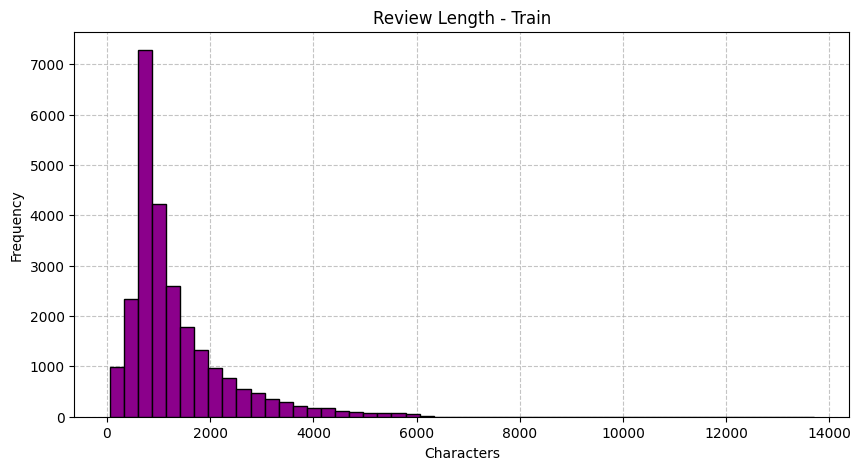


Test set:
Reviews: 25000
Avg length: 1293.79 chars
Labels: label
0    0.5
1    0.5
Name: proportion, dtype: float64


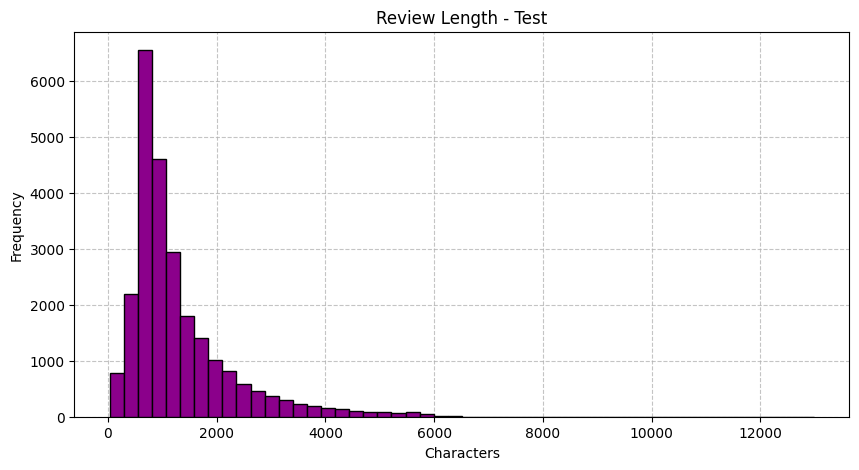


Unsupervised set:
Reviews: 50000
Avg length: 1329.90 chars
Labels: label
-1    1.0
Name: proportion, dtype: float64


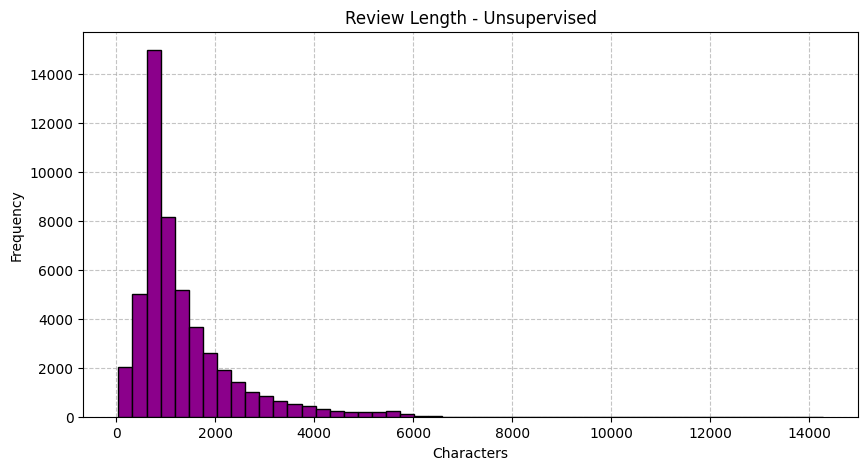

In [64]:
# Basic analysis
def analyze_split(split):
    df = pd.DataFrame(dataset[split])
    print(f"\n{split.capitalize()} set:")
    print(f"Reviews: {len(df)}")
    print(f"Avg length: {df['text'].str.len().mean():.2f} chars")
    print(f"Labels: {df['label'].value_counts(normalize=True)}")

    plt.figure(figsize=(10, 5))
    df['text'].str.len().hist(bins=50, edgecolor='black',
                              color='darkmagenta', zorder=3)
    plt.grid(True, linestyle='--', alpha=0.75, zorder=0)
    plt.title(f"Review Length - {split.capitalize()}")
    plt.xlabel("Characters")
    plt.ylabel("Frequency")
    plt.show()

    return df

for split in ['train', 'test', 'unsupervised']:
    analyze_split(split)

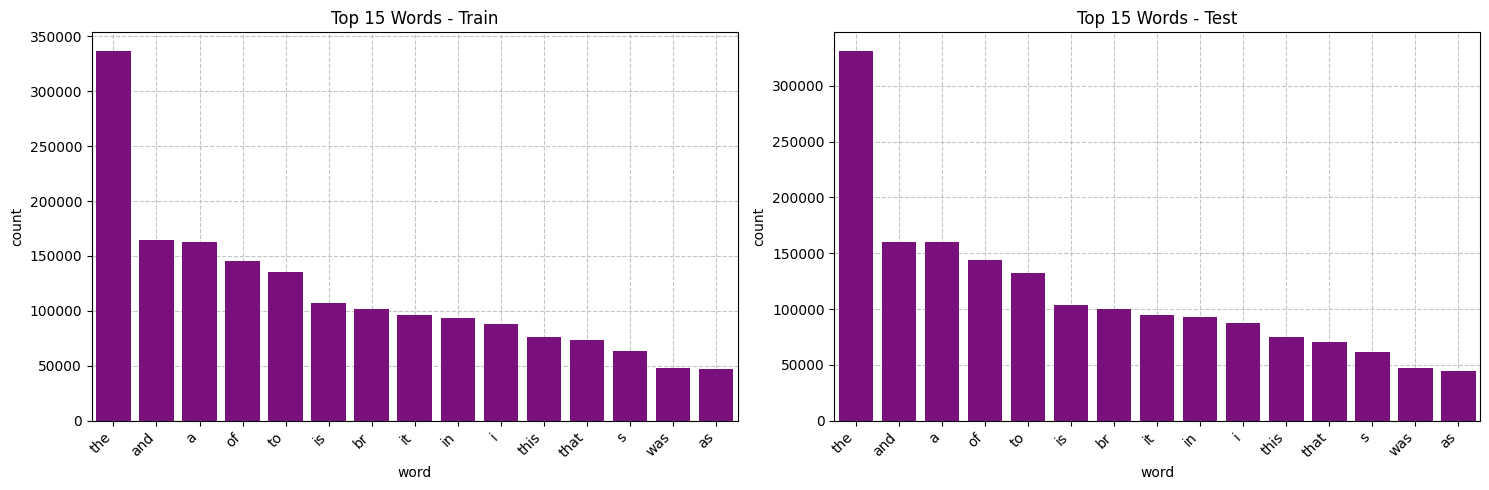

,word,count
0,the,331244
1,and,160301
2,a,159847
3,of,143546
4,to,132400
5,is,103750
6,br,100080
7,it,94390
8,in,92805
9,i,87943


In [65]:
from collections import Counter
import re

def word_frequency_analysis(dataset, splits=['train', 'test'], top_n=15):
    """
    More efficient word frequency analysis for multiple dataset splits.
    """
    # Compile regex pattern once
    pattern = re.compile(r'\W+')

    plt.figure(figsize=(15, 5))

    for i, split in enumerate(splits, 1):
        # Process text in bulk
        text = ' '.join(dataset[split]['text']).lower()
        words = pattern.split(text)

        # Count words (excluding empty strings)
        word_counts = Counter(word for word in words if word)

        # Create subplot for this split
        plt.subplot(1, len(splits), i)

        # Get top words and plot
        top_words = pd.DataFrame(word_counts.most_common(top_n),
                               columns=['word', 'count'])

        sns.barplot(data=top_words, x='word', y='count',
                    color='darkmagenta', zorder=3)
        plt.title(f"Top {top_n} Words - {split.capitalize()}")
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, linestyle='--', alpha=0.75, zorder=0)

    plt.tight_layout()
    plt.show()

    return top_words

# Run analysis for all splits at once
word_frequency_analysis(dataset)

In [66]:
# Sample reivews
print("\nSample reviews:")
for i in range(3):
    print(f"\nReview {i+1}:\n{dataset['train'][i]['text'][:200]}...")


Sample reviews:

Review 1:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev...

Review 2:
"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that ...

Review 3:
If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches ...


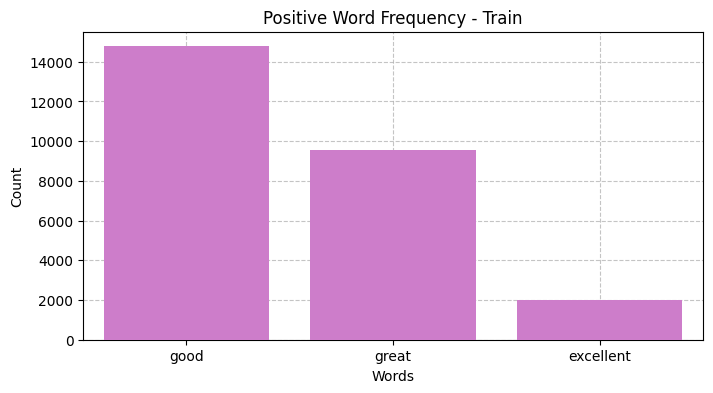

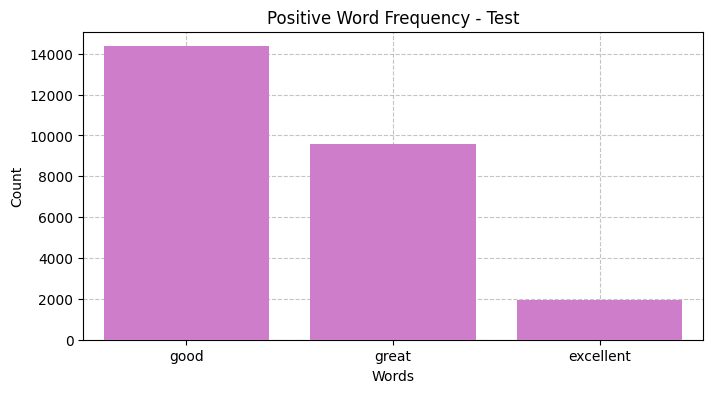

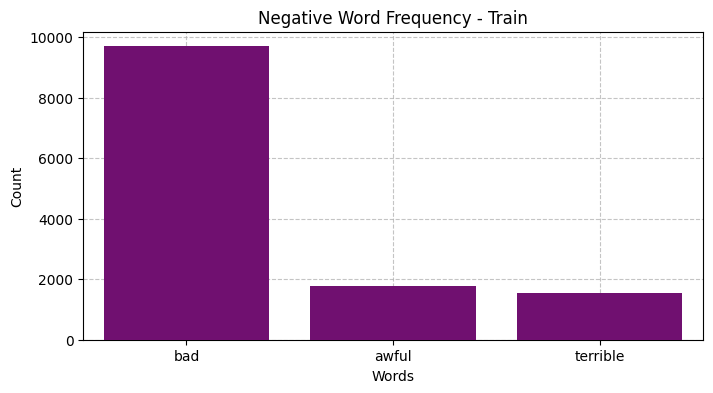

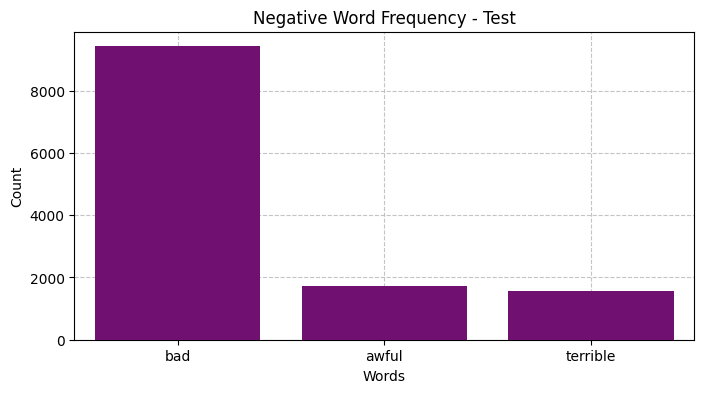

In [67]:
# Sentiment word analysis
import pandas as pd

sentiment_words = {'positive': ['good', 'great', 'excellent'], 'negative': ['bad', 'awful', 'terrible']}

# Assigning colors based on sentiment
sentiment_colors = {'positive': 'orchid', 'negative': 'purple'}

for sentiment, words in sentiment_words.items():
    for split in ['train', 'test']:
        df = pd.DataFrame(dataset[split])
        counts = [df['text'].str.count(word).sum() for word in words]
        plt.figure(figsize=(8, 4))
        sns.barplot(x=words, y=counts,
                    color=sentiment_colors[sentiment], zorder=3)
        plt.grid(True, linestyle='--', alpha=0.75, zorder=0)
        plt.title(f"{sentiment.capitalize()} Word Frequency - {split.capitalize()}")
        plt.ylabel("Count")
        plt.xlabel("Words")
        plt.show()

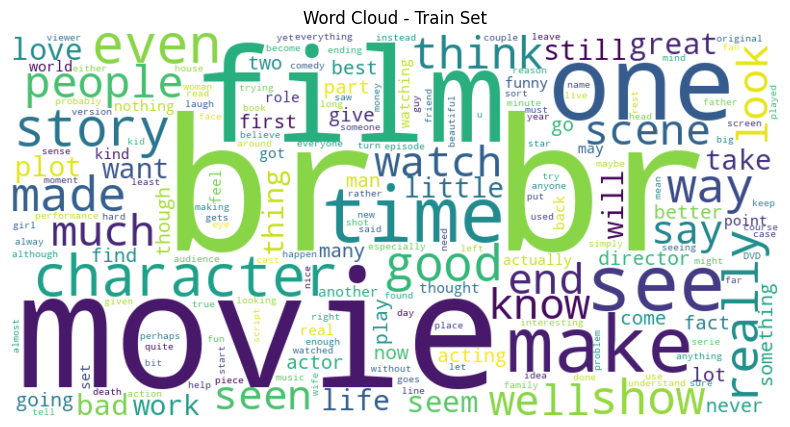

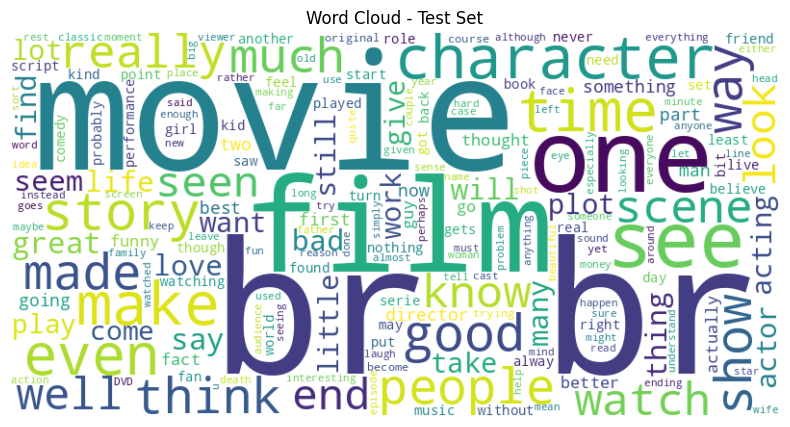

In [68]:
# Wordcloud visualisation
def generate_wordcloud(text, title):
    plt.figure(figsize=(10, 5))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

for split in ['train', 'test']:
    text = ' '.join(dataset[split]['text'])
    generate_wordcloud(text, f"Word Cloud - {split.capitalize()} Set")

<ipython-input-69-682c00d8739c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='length',


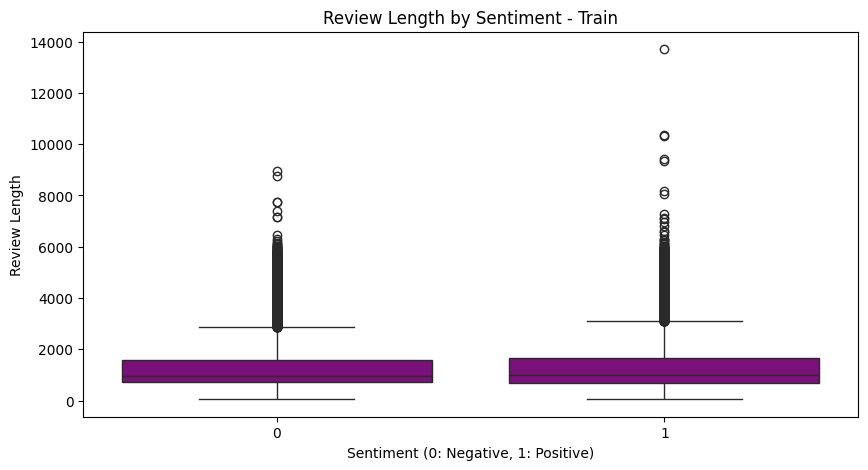

<ipython-input-69-682c00d8739c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='length',


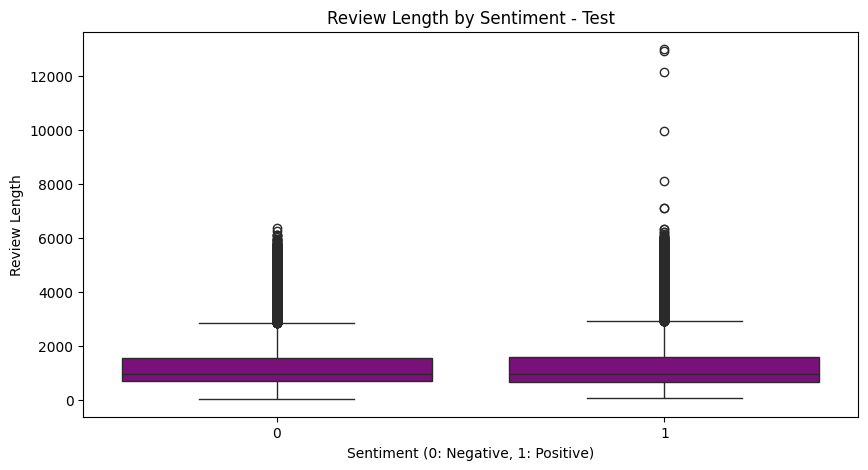

In [69]:
# Review length distribution by sentiment
for split in ['train', 'test']:
    df = pd.DataFrame(dataset[split])
    df['length'] = df['text'].str.len()
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='label', y='length',
                data=df, palette={'0': 'darkmagenta', '1': 'darkmagenta'})
    plt.title(f"Review Length by Sentiment - {split.capitalize()}")
    plt.xlabel("Sentiment (0: Negative, 1: Positive)")
    plt.ylabel("Review Length")
    plt.show()

In [70]:
# N-gram analysis
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

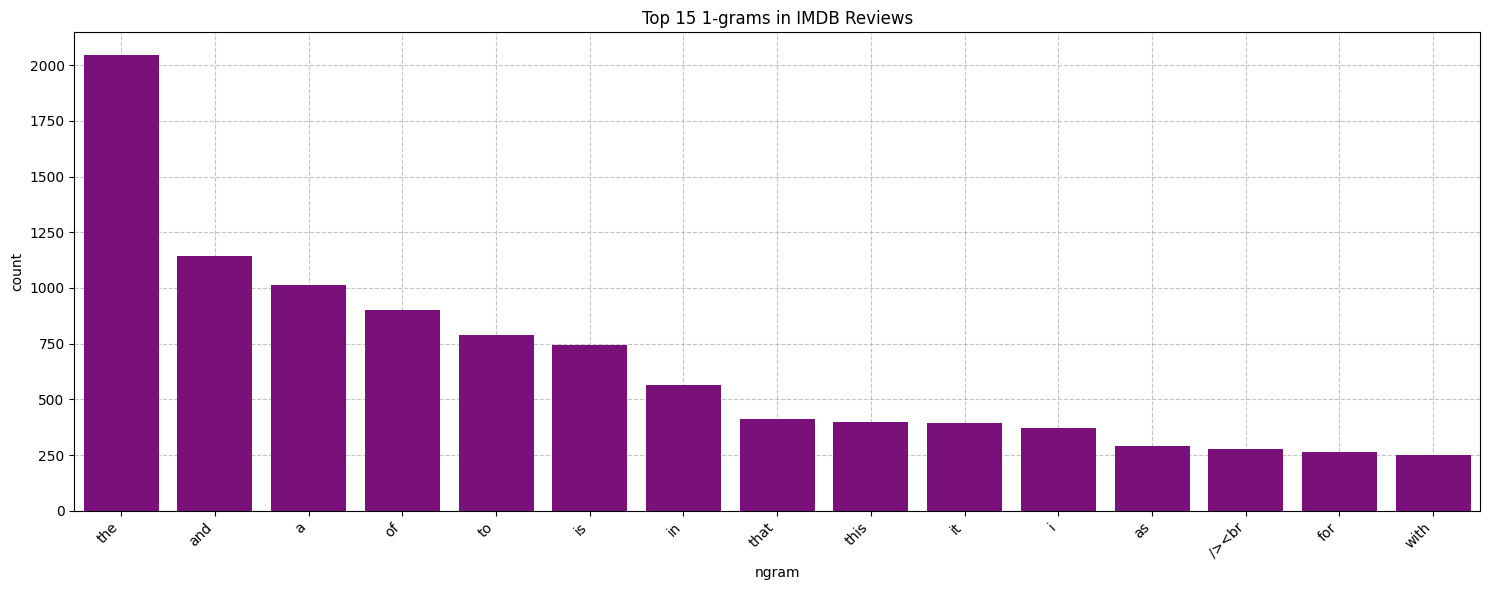

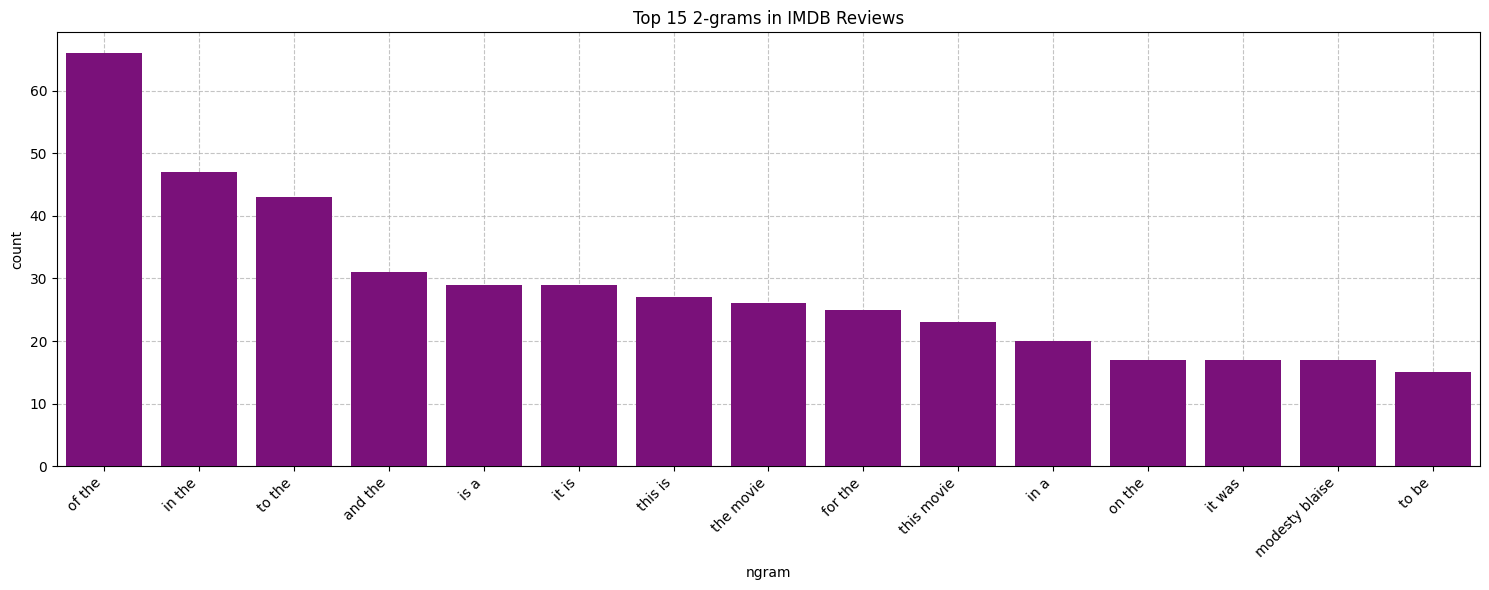

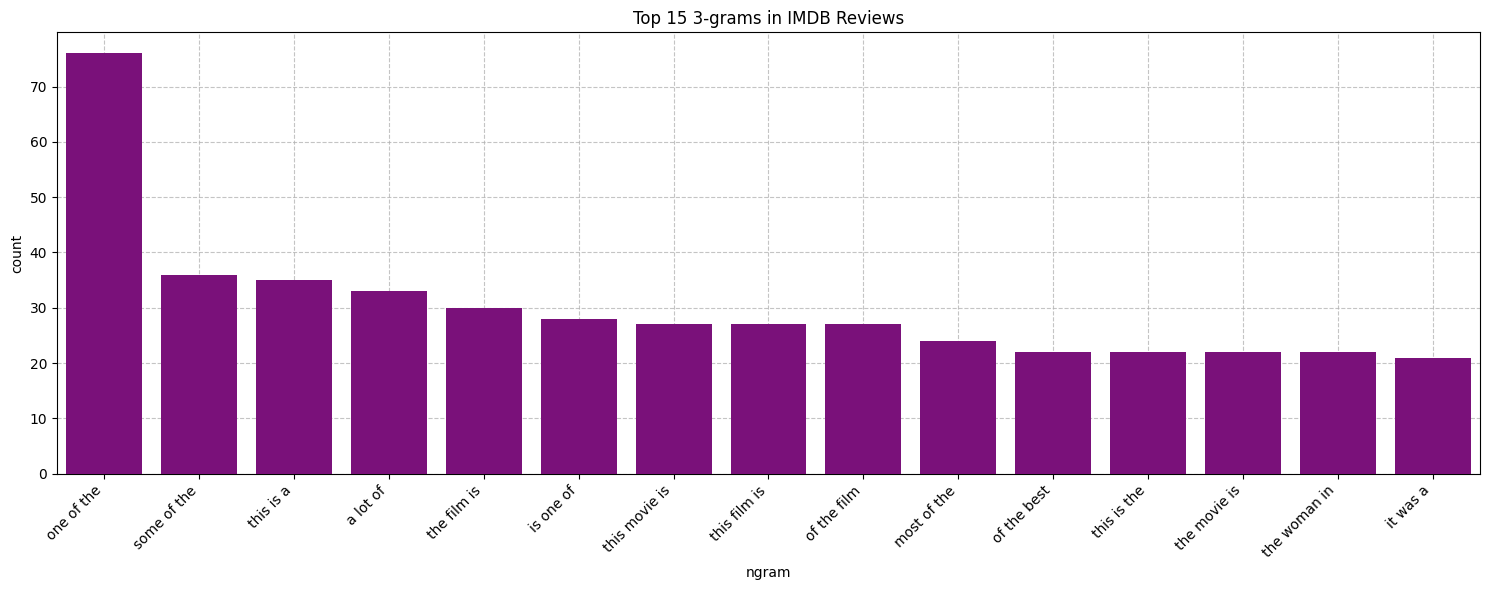

In [71]:
# Function to get multiple N-gram plots
def analyze_multiple_ngrams(dataset, n_values, top_k=15):
    """
    Analyze n-grams for multiple values of `n` from the pre-loaded IMDB dataset.

    Parameters:
    - dataset: dict, the IMDB dataset with train/test splits.
    - n_values: list of ints, the n-gram sizes to analyze.
    - top_k: int, the number of top n-grams to display in the plots.

    Returns:
    - results: dict, top n-grams for each n stored as a DataFrame.
    """
    results = {}

    for n in n_values:
        ngrams = []
        # Process training set texts
        for text in dataset['train']['text']:
            words = text.lower().split()
            text_ngrams = [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
            ngrams.extend(text_ngrams)

            if len(ngrams) > 100000:  # Batch processing to save memory
                ngrams = [pair for pair, count in Counter(ngrams).most_common(top_k * 2)]

        # Count top n-grams
        result_df = pd.DataFrame(Counter(ngrams).most_common(top_k),
                                 columns=['ngram', 'count'])
        results[n] = result_df

        # Plot the results
        plt.figure(figsize=(15, 6))
        sns.barplot(data=result_df, x='ngram', y='count',
                    color='darkmagenta', zorder=3)
        plt.xticks(rotation=45, ha='right')
        plt.title(f'Top {top_k} {n}-grams in IMDB Reviews')
        plt.grid(True, linestyle='--', alpha=0.75, zorder=0)
        plt.tight_layout()
        plt.show()

    return results

# Example Usage
n_values = [1, 2, 3]  # Analyze unigrams, bigrams, and trigrams
ngram_results = analyze_multiple_ngrams(dataset, n_values)

### Pre-processing

#### Text cleaning pipeline

In [6]:
# Contraction handling
CONTRACTION_MAP = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it's": "it is",
    "let's": "let us",
    "shouldn't": "should not",
    "that's": "that is",
    "wasn't": "was not",
    "we'd": "we would",
    "we're": "we are",
    "weren't": "were not",
    "what's": "what is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you're": "you are",
    "you've": "you have"
}

In [7]:
# HTML and Basic text cleaning
def remove_html(text):
    """Remove HTML tags"""
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub('', text)

def expand_contractions(text):
    """Expand contractions using the CONTRACTION_MAP"""
    for contraction, expansion in CONTRACTION_MAP.items():
        text = text.replace(contraction, expansion)
    return text

In [8]:
def clean_text(text):
    """Final cleaning function with all improvements"""
    # Remove HTML
    text = remove_html(text)

    # Handle foreign characters first
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Handle specific patterns
    text = re.sub(r'U\.S\.|U\. S\.', 'USA', text)
    text = re.sub(r'(\d+)/(\d+)', r'\1 of \2', text)
    text = re.sub(r'\((\d+)\)', r'\1.', text)

    # Handle contractions and possessives
    text = expand_contractions(text)
    text = re.sub(r"([a-zA-Z]+)'s\b", r'\1s', text)

    # Convert to lowercase
    text = text.lower()

    # Fix comma spacings
    text = re.sub(r',(?!\s)', r', ', text)

    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', ' ', text)

    # Clean up punctuation
    text = re.sub(r',\s*\.\s*', r'. ', text)  # Remove comma before period
    text = re.sub(r'([.!?])[.!?\s]*([.!?])[.!?\s]*', r'\1 ', text)
    text = re.sub(r'(\d+)\s*\.\s*(\w)', r'\1. \2', text)
    text = re.sub(r'\s*([.,!?])\s*', r'\1 ', text)

    # Clean up multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

In [9]:
# Testing the cleaning functions on a sample review
sample_text = dataset['train'][0]['text']
print("Original:")
print(sample_text[:200])
print("\nCleaned:")
print(clean_text(sample_text)[:200])


Original:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev

Cleaned:
i rented i am curious yellow from my video store because of all the controversy that surrounded it when it was first released in 1967. i also heard that at first it was seized by usa customs if it eve


In [10]:
# Applying the cleaning to a small subset to verify
def analyze_cleaning_results(original, cleaned):
    """Analyze the effects of cleaning with complete text comparison"""
    print(f"Original length: {len(original)}")
    print(f"Cleaned length: {len(cleaned)}")
    print("\nOriginal full text:")
    print(original)
    print("\nCleaned full text:")
    print(cleaned)
    print("\n" + "="*80 + "\n")  # Separator for readability

# Test on first 5 reviews
for i in range(5):
    text = dataset['train'][i]['text']
    cleaned = clean_text(text)
    print(f"\nREVIEW {i+1}:")
    analyze_cleaning_results(text, cleaned)


REVIEW 1:
Original length: 1640
Cleaned length: 1604

Original full text:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered p

In [11]:
# Applying cleaning to the whole set, saving and verifying
from datasets import load_dataset
import random
# Apply cleaning to entire dataset
def clean_dataset(dataset):
   """Apply cleaning to all splits of the dataset"""
   def clean_example(example):
       return {'text': clean_text(example['text'])}

   # Clean all splits
   cleaned_dataset = {}
   for split in dataset.keys():
       print(f"\nCleaning {split} split...")
       cleaned_dataset[split] = dataset[split].map(
           clean_example,
           desc=f"Cleaning {split} split"
       )

       # Verify number of examples
       print(f"Number of examples in {split}: {len(cleaned_dataset[split])}")

   return cleaned_dataset

# Clean the dataset
cleaned_dataset = clean_dataset(dataset)

# Save cleaned dataset
print("\nSaving cleaned dataset...")
for split in cleaned_dataset.keys():
   cleaned_dataset[split].save_to_disk(f"cleaned_imdb_{split}")
print("Dataset saved!")

# Verify cleaning with samples
def verify_cleaning(original_dataset, cleaned_dataset, num_samples=3):
   """Compare original and cleaned samples"""
   for split in original_dataset.keys():
       print(f"\nVerifying {split} split samples:")
       indices = random.sample(range(len(original_dataset[split])), num_samples)

       for idx in indices:
           print(f"\nSample {idx}:")
           print("Original:")
           print(original_dataset[split][idx]['text'][:200])
           print("\nCleaned:")
           print(cleaned_dataset[split][idx]['text'][:200])
           print("-" * 80)

# Verify samples
print("\nVerifying cleaning results...")
verify_cleaning(dataset, cleaned_dataset)


Cleaning train split...


Cleaning train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Number of examples in train: 25000

Cleaning test split...


Cleaning test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Number of examples in test: 25000

Cleaning unsupervised split...


Cleaning unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Number of examples in unsupervised: 50000

Saving cleaned dataset...


Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset saved!

Verifying cleaning results...

Verifying train split samples:

Sample 14711:
Original:
I haven't yet read Kurt Vonnegut's Mother Night (though I've read other books of his, all outstanding pieces of satire and game-changing novel pieces). After seeing Keith Gordon's film adaptation of h

Cleaned:
i have not yet read kurt vonneguts mother night though i ve read other books of his, all outstanding pieces of satire and game changing novel pieces. after seeing keith gordons film adaptation of his 
--------------------------------------------------------------------------------

Sample 12777:
Original:
In the year 1985 (my birth year) Steven Spielberg directed an emotionally strong and unforgettable story of a young African-American girl Celie (Debut role for Whoopi Goldberg) whose life is followed 

Cleaned:
in the year 1985 my birth year steven spielberg directed an emotionally strong and unforgettable story of a young african american girl celie debut role for whoopi gold

#### Preparing for autocompletion

In [12]:
# Loadint the cleaned dataset and setting up parameters
from pathlib import Path
import torch
from datasets import load_from_disk
import random

# Load cleaned dataset
cleaned_train = load_from_disk("cleaned_imdb_train")
cleaned_test = load_from_disk("cleaned_imdb_test")

# Set parameters
INPUT_LENGTH = 100  # characters for input sequence
MIN_TARGET_LENGTH = 20  # minimum characters for target sequence
STRIDE = 50  # stride for sliding window
random.seed(42)  # for reproducibility

In [13]:
# Sequence pair generation funtion
from typing import List, Dict

def create_sequence_pairs(text: str) -> List[Dict[str, str]]:
    """
    Create input-target pairs from text using sliding window

    Args:
        text: Cleaned text string

    Returns:
        List of dictionaries containing input-target pairs
    """
    pairs = []
    text_length = len(text)

    # Skip if text is too short
    if text_length < (INPUT_LENGTH + MIN_TARGET_LENGTH):
        return pairs

    # Find sentence boundaries (periods followed by space)
    sentence_ends = [i for i, char in enumerate(text[:-1])
                    if char == '.' and text[i+1] == ' ']

    start_idx = 0
    while start_idx < (text_length - INPUT_LENGTH - MIN_TARGET_LENGTH):
        # Find appropriate split point near INPUT_LENGTH
        split_point = min((x for x in sentence_ends if x > start_idx + INPUT_LENGTH),
                         default=start_idx + INPUT_LENGTH)

        input_text = text[start_idx:split_point].strip()
        target_text = text[split_point:split_point + INPUT_LENGTH].strip()

        if len(target_text) >= MIN_TARGET_LENGTH:
            pairs.append({
                'input_text': input_text,
                'target_text': target_text,
                'input_length': len(input_text),
                'target_length': len(target_text)
            })

        start_idx += STRIDE

    return pairs

In [14]:
# Process the dataset and create pairs
def process_dataset(dataset):
    """Process dataset into sequence pairs"""
    all_pairs = []

    for idx, example in enumerate(dataset):
        pairs = create_sequence_pairs(example['text'])
        all_pairs.extend(pairs)

        # Progress update
        if (idx + 1) % 1000 == 0:
            print(f"Processed {idx + 1} reviews. Generated {len(all_pairs)} pairs so far.")

    return all_pairs

# Process training and test sets
print("Processing training set...")
train_pairs = process_dataset(cleaned_train)
print(f"\nTotal training pairs generated: {len(train_pairs)}")

print("\nProcessing test set...")
test_pairs = process_dataset(cleaned_test)
print(f"\nTotal test pairs generated: {len(test_pairs)}")

Processing training set...
Processed 1000 reviews. Generated 23360 pairs so far.
Processed 2000 reviews. Generated 45404 pairs so far.
Processed 3000 reviews. Generated 68388 pairs so far.
Processed 4000 reviews. Generated 91707 pairs so far.
Processed 5000 reviews. Generated 116033 pairs so far.
Processed 6000 reviews. Generated 139626 pairs so far.
Processed 7000 reviews. Generated 162863 pairs so far.
Processed 8000 reviews. Generated 187632 pairs so far.
Processed 9000 reviews. Generated 211693 pairs so far.
Processed 10000 reviews. Generated 233829 pairs so far.
Processed 11000 reviews. Generated 255832 pairs so far.
Processed 12000 reviews. Generated 279093 pairs so far.
Processed 13000 reviews. Generated 301774 pairs so far.
Processed 14000 reviews. Generated 327954 pairs so far.
Processed 15000 reviews. Generated 351391 pairs so far.
Processed 16000 reviews. Generated 375823 pairs so far.
Processed 17000 reviews. Generated 400718 pairs so far.
Processed 18000 reviews. Generated

#### Formatting  and saving the dataset





In [15]:
# Import tokenizer and setup
from transformers import GPT2Tokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
import numpy as np

# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
tokenizer.pad_token = tokenizer.eos_token

# Constants
MAX_INPUT_LENGTH = 512  # maximum tokens for input
MAX_TARGET_LENGTH = 128  # maximum tokens for target
BATCH_SIZE = 16

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

In [16]:
# Creating a custom dataset class
class IMDBAutocompleteDataset(Dataset):
    """Custom dataset for IMDB autocompletion task"""
    def __init__(self, pairs, tokenizer, max_input_length, max_target_length):
        self.pairs = pairs
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]

        # Tokenize input and target
        input_encoding = self.tokenizer(
            pair['input_text'],
            max_length=self.max_input_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        target_encoding = self.tokenizer(
            pair['target_text'],
            max_length=self.max_target_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': input_encoding['input_ids'].squeeze(),
            'attention_mask': input_encoding['attention_mask'].squeeze(),
            'labels': target_encoding['input_ids'].squeeze()
        }

In [17]:
# creating datasets and verifying
# Create datasets
train_dataset = IMDBAutocompleteDataset(
    train_pairs,
    tokenizer,
    MAX_INPUT_LENGTH,
    MAX_TARGET_LENGTH
)

test_dataset = IMDBAutocompleteDataset(
    test_pairs,
    tokenizer,
    MAX_INPUT_LENGTH,
    MAX_TARGET_LENGTH
)

# Create sample dataloader for verification
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Verify format
def verify_dataset(dataset, loader):
    print(f"Dataset size: {len(dataset)}")

    # Get first batch
    batch = next(iter(loader))
    print("\nBatch shapes:")
    for key, value in batch.items():
        print(f"{key}: {value.shape}")

    # Decode sample
    sample_idx = 0
    input_text = tokenizer.decode(batch['input_ids'][sample_idx])
    target_text = tokenizer.decode(batch['labels'][sample_idx])

    print("\nSample decoded text:")
    print("Input:", input_text[:100], "...")
    print("Target:", target_text[:100], "...")

print("Verifying training dataset:")
verify_dataset(train_dataset, train_loader)

Verifying training dataset:
Dataset size: 593349

Batch shapes:
input_ids: torch.Size([16, 512])
attention_mask: torch.Size([16, 512])
labels: torch.Size([16, 128])

Sample decoded text:
Input: e time have to be appreciated, and given those limitations john cromwell does a very good job direct ...
Target: . a fine example of his skillful direction is the scene set at victoria station. it is beautifully c ...


In [18]:
# Saving processed daatsets
def save_processed_data(dataset, filename):
    """Save processed dataset"""
    save_dict = {
        'dataset': dataset,
        'tokenizer_name': 'distilgpt2',
        'max_input_length': MAX_INPUT_LENGTH,
        'max_target_length': MAX_TARGET_LENGTH
    }

    with open(filename, 'wb') as f:
        pickle.dump(save_dict, f)

# Save datasets
print("Saving processed datasets...")
save_processed_data(train_dataset, 'imdb_autocomplete_train.pkl')
save_processed_data(test_dataset, 'imdb_autocomplete_test.pkl')
print("Datasets saved!")

# Save tokenizer config separately
tokenizer.save_pretrained('./tokenizer')
print("Tokenizer saved!")

Saving processed datasets...
Datasets saved!
Tokenizer saved!


In [19]:
import os
import pickle

def check_dataset_files():
    """Check saved dataset files and their details"""
    files_to_check = [
        'imdb_autocomplete_train.pkl',
        'imdb_autocomplete_test.pkl',
        './tokenizer'
    ]

    print("Checking dataset files:")
    for file_path in files_to_check:
        if os.path.exists(file_path):
            if file_path.endswith('.pkl'):
                # Load and check pickle file
                with open(file_path, 'rb') as f:
                    data = pickle.load(f)
                    print(f"\n{file_path}:")
                    print(f"Keys in save_dict: {data.keys()}")
                    if 'dataset' in data:
                        dataset = data['dataset']
                        print(f"Dataset size: {len(dataset)} samples")
                        print(f"Sample structure:")
                        print(dataset[0])  # Print first sample structure
            else:
                # Directory info
                print(f"\n{file_path}:")
                print(f"Directory exists: {os.path.isdir(file_path)}")
        else:
            print(f"\nWarning: {file_path} not found")

# Run check
check_dataset_files()

Checking dataset files:

imdb_autocomplete_train.pkl:
Keys in save_dict: dict_keys(['dataset', 'tokenizer_name', 'max_input_length', 'max_target_length'])
Dataset size: 593349 samples
Sample structure:
{'input_ids': tensor([   72, 26399,  1312,   716, 11040,  7872,   422,   616,  2008,  3650,
          780,   286,   477,   262, 10386,   326, 11191,   340,   618,   340,
          373,   717,  2716,   287, 15904, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
    

Analyzing training dataset...


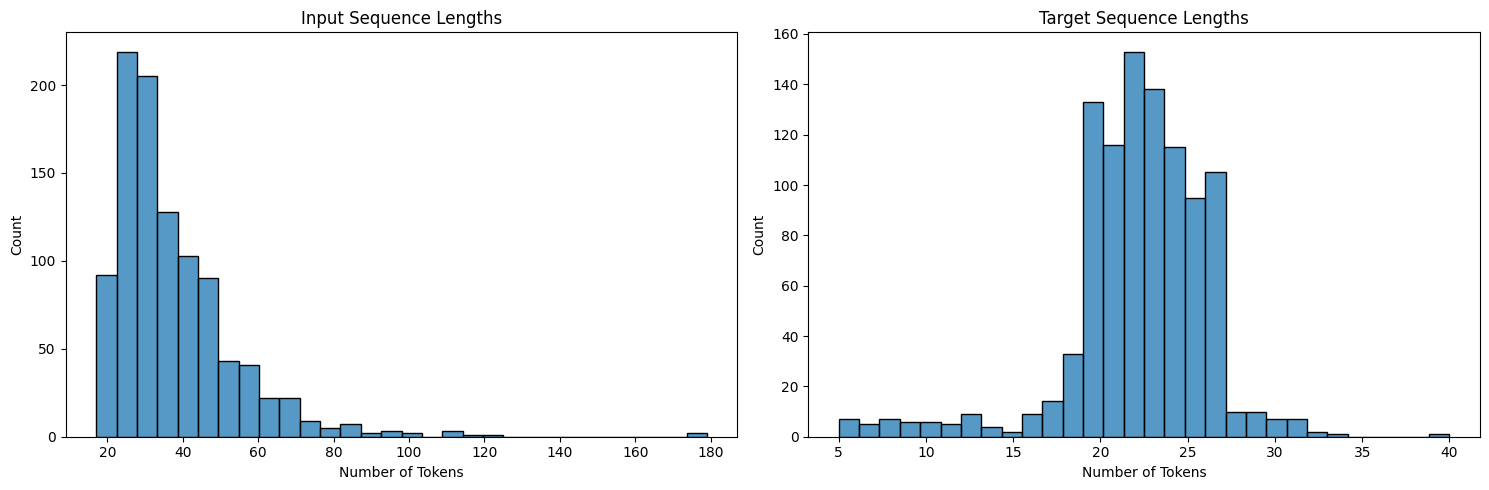


Sequence Length Statistics:
Input - Mean: 37.30, Median: 33.00, Max: 179
Target - Mean: 22.11, Median: 22.00, Max: 40

Validation Checks:
Samples with empty inputs: 0
Samples with empty targets: 0
Samples with full-length inputs: 0
Samples with full-length targets: 0

Detailed Quality Checks:

Sample 1:
Input: ty everywhere but he is my favourite hong kong moviestar so far way better than nicolas tse neverthe ...
Target: . without a doubt this film is a work of art from the beginning to the end. i even thought that only ...
Checks:
- Input contains padding: True
- Target contains padding: True
- Input/Target relation makes sense: True
--------------------------------------------------------------------------------

Sample 2:
Input: t his deserved 3rd bond outing it was a laugh. belushi brought some good humour to his part and dalt ...
Target: . his part was liked a camped up version of jack nicholson in a few good men. the other brit in it w ...
Checks:
- Input contains padding: True


In [20]:
# Some additional validation and checks
# Cell - Additional Validation and Statistics
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def analyze_dataset_statistics(dataset, tokenizer, num_samples=1000):
    """Analyze tokenized dataset statistics"""
    # Sample random indices
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    # Collect statistics
    input_token_lengths = []
    target_token_lengths = []
    input_vocab = Counter()
    target_vocab = Counter()

    for idx in indices:
        sample = dataset[idx]

        # Count non-padding tokens
        input_length = (sample['input_ids'] != tokenizer.pad_token_id).sum().item()
        target_length = (sample['labels'] != tokenizer.pad_token_id).sum().item()

        input_token_lengths.append(input_length)
        target_token_lengths.append(target_length)

        # Collect vocabulary statistics
        input_vocab.update(sample['input_ids'].tolist())
        target_vocab.update(sample['labels'].tolist())

    # Plot distributions
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(input_token_lengths, bins=30)
    plt.title('Input Sequence Lengths')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    sns.histplot(target_token_lengths, bins=30)
    plt.title('Target Sequence Lengths')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\nSequence Length Statistics:")
    print(f"Input - Mean: {np.mean(input_token_lengths):.2f}, "
          f"Median: {np.median(input_token_lengths):.2f}, "
          f"Max: {max(input_token_lengths)}")
    print(f"Target - Mean: {np.mean(target_token_lengths):.2f}, "
          f"Median: {np.median(target_token_lengths):.2f}, "
          f"Max: {max(target_token_lengths)}")

    # Validation checks
    print("\nValidation Checks:")
    print(f"Samples with empty inputs: {sum(l == 0 for l in input_token_lengths)}")
    print(f"Samples with empty targets: {sum(l == 0 for l in target_token_lengths)}")
    print(f"Samples with full-length inputs: {sum(l == MAX_INPUT_LENGTH for l in input_token_lengths)}")
    print(f"Samples with full-length targets: {sum(l == MAX_TARGET_LENGTH for l in target_token_lengths)}")

# Run analysis
print("Analyzing training dataset...")
analyze_dataset_statistics(train_dataset, tokenizer)

# Additional quality checks
def check_data_quality(dataset, tokenizer, num_samples=5):
    """Perform detailed quality checks on random samples"""
    print("\nDetailed Quality Checks:")

    indices = random.sample(range(len(dataset)), num_samples)
    for i, idx in enumerate(indices):
        sample = dataset[idx]

        # Decode texts
        input_text = tokenizer.decode(sample['input_ids'])
        target_text = tokenizer.decode(sample['labels'])

        print(f"\nSample {i+1}:")
        print("Input:", input_text[:100], "..." if len(input_text) > 100 else "")
        print("Target:", target_text[:100], "..." if len(target_text) > 100 else "")

        # Check for potential issues
        print("Checks:")
        print(f"- Input contains padding: {tokenizer.pad_token in input_text}")
        print(f"- Target contains padding: {tokenizer.pad_token in target_text}")
        print(f"- Input/Target relation makes sense: {target_text.strip().startswith('.')}")
        print("-" * 80)

# Run quality checks
check_data_quality(train_dataset, tokenizer)

#### Length filtering for optimization

In [21]:
# Loading the pre-processed datasets for length-filtering functions
# 1. Load preprocessed datasets
with open('imdb_autocomplete_train.pkl', 'rb') as f:
    train_data = pickle.load(f)
    train_dataset = train_data['dataset']

with open('imdb_autocomplete_test.pkl', 'rb') as f:
    test_data = pickle.load(f)
    test_dataset = test_data['dataset']

In [22]:
def filter_sequences_by_length(dataset, min_percentile=20, max_percentile=80):
    """Filter sequences based on length percentiles"""

    def get_sequence_length(example):
        # Use attention mask to get actual sequence length
        return torch.sum(example['attention_mask']).item()

    # Calculate sequence lengths
    lengths = [get_sequence_length(example) for example in dataset]

    # Calculate percentile thresholds
    min_len = np.percentile(lengths, min_percentile)
    max_len = np.percentile(lengths, max_percentile)

    print(f"Length thresholds:")
    print(f"Min (percentile {min_percentile}): {min_len}")
    print(f"Max (percentile {max_percentile}): {max_len}")

    # Filter dataset
    filtered_indices = [i for i, length in enumerate(lengths)
                       if min_len <= length <= max_len]

    return filtered_indices, min_len, max_len

In [23]:
# Filtering the datasets
# 3. Apply filtering
print("Filtering train dataset...")
train_filtered_indices, train_min_len, train_max_len = filter_sequences_by_length(train_dataset)

print("\nFiltering test dataset...")
test_filtered_indices, test_min_len, test_max_len = filter_sequences_by_length(test_dataset)

print(f"\nResults:")
print(f"Train: {len(train_filtered_indices)} samples after filtering (from {len(train_dataset)})")
print(f"Test: {len(test_filtered_indices)} samples after filtering (from {len(test_dataset)})")

Filtering train dataset...
Length thresholds:
Min (percentile 20): 26.0
Max (percentile 80): 48.0

Filtering test dataset...
Length thresholds:
Min (percentile 20): 26.0
Max (percentile 80): 48.0

Results:
Train: 364342 samples after filtering (from 593349)
Test: 354393 samples after filtering (from 577732)


#### Stratified sampling code for optimizing dataset

In [24]:
from tqdm import tqdm
def create_stratified_sample_fast(dataset, filtered_indices, sample_fraction=0.3):
    """Faster version of stratified sampling using batched processing"""
    print(f"Creating stratified sample from {len(filtered_indices)} sequences (fast version)...")

    filtered_indices = np.array(filtered_indices)

    # Get lengths
    batch_size = 1000
    lengths = []
    for i in tqdm(range(0, len(filtered_indices), batch_size), desc="Processing lengths"):
        batch_indices = filtered_indices[i:i+batch_size]
        batch_lengths = [torch.sum(dataset[idx]['attention_mask']).item()
                        for idx in batch_indices]
        lengths.extend(batch_lengths)
    lengths = np.array(lengths)

    # Modified binning logic
    bin_boundaries = np.percentile(lengths, [33.33, 66.67])  # Changed to ensure three equal bins
    bins = ['short', 'medium', 'long']
    length_bins = np.zeros_like(lengths, dtype=int)
    length_bins[lengths > bin_boundaries[0]] = 1
    length_bins[lengths > bin_boundaries[1]] = 2

    # Sample from each bin
    sampled_indices = []
    n_per_bin = int(len(filtered_indices) * sample_fraction / 3)  # Equal samples per bin

    for bin_id, bin_name in enumerate(bins):
        bin_indices = filtered_indices[length_bins == bin_id]
        if len(bin_indices) > 0:  # Only sample if bin has indices
            n_samples = min(n_per_bin, len(bin_indices))  # Prevent sampling more than available
            sampled = np.random.choice(bin_indices, size=n_samples, replace=False)
            sampled_indices.extend(sampled)

    sampled_indices = np.array(sampled_indices)
    np.random.shuffle(sampled_indices)

    # Print statistics
    print(f"\nStratified Sampling Results:")
    print(f"Original filtered size: {len(filtered_indices)}")
    print(f"Sampled size: {len(sampled_indices)}")
    print("\nDistribution in sample:")
    for bin_id, name in enumerate(bins):
        count = sum(length_bins[np.isin(filtered_indices, sampled_indices)] == bin_id)
        print(f"{name}: {count} samples ({count/len(sampled_indices):.2%})")

    return sampled_indices.tolist()

# Apply stratified sampling to filtered datasets
print("Creating stratified samples...")
train_sampled_indices = create_stratified_sample_fast(train_dataset, train_filtered_indices)
test_sampled_indices = create_stratified_sample_fast(test_dataset, test_filtered_indices)

# Create new datasets with sampled indices
def create_final_dataset(dataset, indices, save_name):
   """Create and save final sampled dataset"""
   sampled_dataset = [dataset[i] for i in indices]

   save_dict = {
       'dataset': sampled_dataset,
       'tokenizer_name': 'distilgpt2',
       'max_input_length': MAX_INPUT_LENGTH,
       'max_target_length': MAX_TARGET_LENGTH
   }

   with open(f'{save_name}_sampled.pkl', 'wb') as f:
       pickle.dump(save_dict, f)

   return sampled_dataset

# Create final datasets
print("\nSaving sampled datasets...")
train_final = create_final_dataset(train_dataset, train_sampled_indices, 'imdb_autocomplete_train')
test_final = create_final_dataset(test_dataset, test_sampled_indices, 'imdb_autocomplete_test')

print("\nFinal dataset sizes:")
print(f"Train: {len(train_final)}")
print(f"Test: {len(test_final)}")

Creating stratified samples...
Creating stratified sample from 364342 sequences (fast version)...


Processing lengths: 100%|██████████| 365/365 [06:54<00:00,  1.14s/it]



Stratified Sampling Results:
Original filtered size: 364342
Sampled size: 109302

Distribution in sample:
short: 36434 samples (33.33%)
medium: 36434 samples (33.33%)
long: 36434 samples (33.33%)
Creating stratified sample from 354393 sequences (fast version)...


Processing lengths: 100%|██████████| 355/355 [06:41<00:00,  1.13s/it]



Stratified Sampling Results:
Original filtered size: 354393
Sampled size: 106317

Distribution in sample:
short: 35439 samples (33.33%)
medium: 35439 samples (33.33%)
long: 35439 samples (33.33%)

Saving sampled datasets...

Final dataset sizes:
Train: 109302
Test: 106317


## Fine-tuning DistilGPT-2 on the IMDB dataset

### Model setup

#### Memory check and imports

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
import numpy as np
import os
from tqdm import tqdm

# Clear GPU memory
torch.cuda.empty_cache()
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")

GPU available: True
GPU Memory: 15.84 GB


#### Define training config and initialize


In [ ]:
class TrainingConfig:
    """Training configuration with memory optimization"""
    # Model parameters
    model_name = 'distilgpt2'
    max_length = 256
    batch_size = 4
    gradient_accumulation_steps = 4

    # Optimizer parameters
    learning_rate = 5e-5
    max_grad_norm = 1.0
    weight_decay = 0.01

    # Training parameters
    num_epochs = 2
    #warmup_steps = 1000
    warmup_steps = 100
    warmup_ratio = 0.1

    # Logging and saving
    #save_steps = 1000
    #eval_steps = 1000
    save_steps = 100
    eval_steps = 100
    checkpoint_dir = "checkpoints"

    # Hardware
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_workers = 2

# Initialize config
config = TrainingConfig()

#### Loading the datasets

In [25]:
import pickle

# Load preprocessed datasets
print("Loading sampled datasets...")
try:
    with open('imdb_autocomplete_train_sampled.pkl', 'rb') as f:
        train_data = pickle.load(f)
        train_dataset = train_data['dataset']

    with open('imdb_autocomplete_test_sampled.pkl', 'rb') as f:
        test_data = pickle.load(f)
        test_dataset = test_data['dataset']

    print(f"Loaded sampled datasets:")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Testing samples: {len(test_dataset)}")

    # Verify other saved configurations
    print(f"\nTokenizer name: {train_data['tokenizer_name']}")
    print(f"Max input length: {train_data['max_input_length']}")
    print(f"Max target length: {train_data['max_target_length']}")

except FileNotFoundError:
    print("Sampled dataset files not found. Make sure filtering and sampling steps completed.")
except Exception as e:
    print(f"Error loading datasets: {e}")

Loading sampled datasets...
Loaded sampled datasets:
Training samples: 109302
Testing samples: 106317

Tokenizer name: distilgpt2
Max input length: 512
Max target length: 128


In [26]:
# Creating a sample dataset
def create_dataset_subset(dataset, num_samples=10000):
    """Create a smaller subset of the dataset"""
    total_samples = len(dataset)
    indices = torch.randperm(total_samples)[:num_samples]
    subset = torch.utils.data.Subset(dataset, indices)
    print(f"Created subset with {len(subset)} samples")
    return subset

# Create subsets
print("Creating subsets...")
train_subset = create_dataset_subset(train_dataset, num_samples=10000)
test_subset = create_dataset_subset(test_dataset, num_samples=1000)

Creating subsets...
Created subset with 10000 samples
Created subset with 1000 samples


In [27]:
# First verification - Check Dataset
print("Verifying dataset samples...")
for i in range(3):
    sample = train_dataset[i]
    print(f"\nSample {i+1}:")
    print(f"Input shape: {sample['input_ids'].shape}")
    print(f"Label shape: {sample['labels'].shape}")
    print(f"Mask shape: {sample['attention_mask'].shape}")

Verifying dataset samples...

Sample 1:
Input shape: torch.Size([512])
Label shape: torch.Size([128])
Mask shape: torch.Size([512])

Sample 2:
Input shape: torch.Size([512])
Label shape: torch.Size([128])
Mask shape: torch.Size([512])

Sample 3:
Input shape: torch.Size([512])
Label shape: torch.Size([128])
Mask shape: torch.Size([512])


#### Setting up model and tokenizer

In [ ]:
# Setting up tokenizers
tokenizer = GPT2Tokenizer.from_pretrained(config.model_name)
tokenizer.pad_token = tokenizer.eos_token

# Model setup
model = GPT2LMHeadModel.from_pretrained(config.model_name)
model.to(config.device)

# Print model size
model_size = sum(t.numel() for t in model.parameters())
print(f"Model size: {model_size:,} parameters")

"""# Memory optimized data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True if config.device=='cuda' else False,
    drop_last=True
)

val_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True if config.device=='cuda' else False,
    drop_last=True
)"""
# Memory optimized data loaders
train_loader = DataLoader(
    train_subset,  # Changed from train_dataset to train_subset
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True if config.device=='cuda' else False,
    drop_last=True
)

val_loader = DataLoader(
    test_subset,  # Changed from test_dataset to test_subset
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True if config.device=='cuda' else False,
    drop_last=True
)

In [ ]:
# Verification
# Second verification - Check Batch Processing
print("\nVerifying batch formation...")
batch = next(iter(train_loader))
print("\nBatch details:")
print(f"Input: {batch['input_ids'].shape}")
print(f"Labels: {batch['labels'].shape}")
print(f"Mask: {batch['attention_mask'].shape}")
print("\nNon-pad tokens in input:", (batch['input_ids'] != tokenizer.pad_token_id).sum())
print("Non-pad tokens in labels:", (batch['labels'] != tokenizer.pad_token_id).sum())

#### Setting up optimizer and scheduler

In [ ]:
# Initialize optimizer
from torch.optim import AdamW  # Using PyTorch's AdamW

optimizer = AdamW(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

# Calculate total training steps
num_training_steps = len(train_loader) * config.num_epochs
num_warmup_steps = config.warmup_steps

# Initialize scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

print(f"Total training steps: {num_training_steps}")
print(f"Warmup steps: {num_warmup_steps}")

#### Setting training utilities

In [ ]:
class TrainingStats:
    """Class to track training statistics"""
    def __init__(self):
        self.running_loss = 0
        self.steps = 0
        self.epoch_losses = []

    def update(self, loss):
        self.running_loss += loss
        self.steps += 1

    def average(self):
        return self.running_loss / self.steps if self.steps > 0 else 0

    def log_epoch(self):
        avg_loss = self.average()
        self.epoch_losses.append(avg_loss)
        return avg_loss

    def reset(self):
        self.running_loss = 0
        self.steps = 0

class ModelMetrics:
    """Enhanced metrics tracking"""
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.perplexities = []
        self.best_loss = float('inf')
        self.best_perplexity = float('inf')
        self.epochs = []

    def update_train(self, epoch, loss):
        self.epochs.append(epoch)
        self.train_losses.append(loss)

    def update_validation(self, loss, perplexity):
        self.val_losses.append(loss)
        self.perplexities.append(perplexity)

        # Track best metrics
        if loss < self.best_loss:
            self.best_loss = loss
        if perplexity < self.best_perplexity:
            self.best_perplexity = perplexity
            return True
        return False

    def get_summary(self):
        return {
            'best_loss': self.best_loss,
            'best_perplexity': self.best_perplexity,
            'final_loss': self.val_losses[-1] if self.val_losses else None,
            'final_perplexity': self.perplexities[-1] if self.perplexities else None
        }

# Initialize metrics
model_metrics = ModelMetrics()

def save_checkpoint(model, optimizer, scheduler, epoch, loss, path):
    """Save model checkpoint"""
    checkpoint_path = os.path.join(path, f'checkpoint-epoch-{epoch}.pt')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

# Create directory for checkpoints
os.makedirs('checkpoints', exist_ok=True)

# Initialize training statistics
train_stats = TrainingStats()
val_stats = TrainingStats()

In [ ]:
# Verification
# Third verification - Check Loss Computation
def verify_shapes(batch):
    """Debug shape transformations"""
    input_ids = batch['input_ids'].to(config.device)
    labels = batch['labels'].to(config.device)

    print("Original shapes:")
    print(f"Input ids: {input_ids.shape}")
    print(f"Labels: {labels.shape}")

    # Shift for next-token prediction
    shift_logits = input_ids[..., :-1].contiguous()
    shift_labels = labels[..., 1:].contiguous()

    print("\nAfter shifting:")
    print(f"Shifted logits: {shift_logits.shape}")
    print(f"Shifted labels: {shift_labels.shape}")

    # Show flattened dimensions
    print("\nFlattened shapes:")
    print(f"Flattened logits: {shift_logits.view(-1).shape}")
    print(f"Flattened labels: {shift_labels.view(-1).shape}")

# Run shape verification
print("\nVerifying shape transformations...")
sample_batch = next(iter(train_loader))
verify_shapes(sample_batch)

### Training configuration

#### Defining loss function and metrics

In [ ]:
def compute_loss(model_output, labels):
    """Compute loss with proper shape handling"""
    # Get logits from model output
    logits = model_output.logits

    # Shift logits and labels for next token prediction
    # Shift logits to the left and labels to the right
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()

    # Flatten the tensors
    vocab_size = shift_logits.size(-1)
    shift_logits = shift_logits.view(-1, vocab_size)
    shift_labels = shift_labels.view(-1)

    # Compute loss
    loss_fct = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    loss = loss_fct(shift_logits, shift_labels)

    return loss

def compute_perplexity(loss):
    """Compute perplexity from loss"""
    return torch.exp(loss)

#### Setting up evsluation metrics

In [ ]:
"""class EvaluationMetrics:
    #Track evaluation metrics
    def __init__(self):
        self.losses = []
        self.perplexities = []
        self.best_loss = float('inf')

    def update(self, loss, perplexity):
        self.losses.append(loss)
        self.perplexities.append(perplexity)

        # Check if this is the best model
        if loss < self.best_loss:
            self.best_loss = loss
            return True
        return False

    def get_metrics(self):
        return {
            'avg_loss': sum(self.losses) / len(self.losses),
            'avg_perplexity': sum(self.perplexities) / len(self.perplexities),
            'best_loss': self.best_loss
        }

metrics = EvaluationMetrics()"""
# Updated evaluation metrics for the subset
# Initialize metrics tracker
class EvaluationMetrics:
    """Track evaluation metrics"""
    def __init__(self):
        self.losses = []
        self.perplexities = []
        self.best_loss = float('inf')
        self.current_loss = None

    def update(self, loss, perplexity=None):
        self.losses.append(loss)
        self.current_loss = loss
        if perplexity:
            self.perplexities.append(perplexity)

        if loss < self.best_loss:
            self.best_loss = loss
            return True
        return False

    def get_metrics(self):
        if not self.losses:
            return {
                'avg_loss': float('inf'),
                'best_loss': float('inf')
            }
        return {
            'avg_loss': sum(self.losses) / len(self.losses),
            'best_loss': self.best_loss
        }

# Initialize metrics
metrics = EvaluationMetrics()

#### Defining a validation function and saving the evaluation results

In [ ]:
def validate(model, val_loader, model_metrics, tokenizer, generate_samples=True):
    """Run validation loop with perplexity calculation"""
    model.eval()
    val_stats = TrainingStats()
    all_perplexities = []

    print("\nRunning validation...")
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            # Move batch to device
            input_ids = batch['input_ids'].to(config.device)
            labels = batch['labels'].to(config.device)
            attention_mask = batch['attention_mask'].to(config.device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=None,
                return_dict=True
            )

            # Calculate loss
            logits = outputs.logits
            target_length = labels.size(1) - 1
            relevant_logits = logits[:, -target_length:, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()

            vocab_size = relevant_logits.size(-1)
            flat_logits = relevant_logits.reshape(-1, vocab_size)
            flat_labels = shift_labels.reshape(-1)

            loss = torch.nn.functional.cross_entropy(
                flat_logits,
                flat_labels,
                ignore_index=tokenizer.pad_token_id
            )

            # Calculate perplexity
            perplexity = torch.exp(loss)
            all_perplexities.append(perplexity.item())

            # Update statistics
            val_stats.update(loss.item())

            # Update metrics using ModelMetrics update_validation method
            model_metrics.update_validation(loss.item(), perplexity.item())

    # Calculate average metrics
    avg_loss = val_stats.average()
    avg_perplexity = sum(all_perplexities) / len(all_perplexities)

    print(f"\nValidation Metrics:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Average Perplexity: {avg_perplexity:.4f}")

    return avg_loss, avg_perplexity

In [ ]:
def save_evaluation_results(metrics, save_dir='evaluation_results'):
    """Save evaluation metrics and plots"""
    import json
    import matplotlib.pyplot as plt

    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Save metrics to JSON
    metrics_summary = metrics.get_summary()
    with open(os.path.join(save_dir, 'metrics.json'), 'w') as f:
        json.dump(metrics_summary, f, indent=4)

    # Plot training curves
    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(metrics.epochs, metrics.train_losses, label='Train Loss')
    plt.plot(metrics.epochs, metrics.val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Perplexity plot
    plt.subplot(1, 2, 2)
    plt.plot(metrics.epochs, metrics.perplexities, label='Validation Perplexity')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.title('Validation Perplexity')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_curves.png'))
    plt.close()

    print(f"\nEvaluation results saved to {save_dir}")

### Training loop implementation

#### Defining main training steps

In [ ]:
def training_step(model, batch, optimizer, scheduler, step):
    """Single training step handling different input/target lengths"""
    # Move batch to device
    input_ids = batch['input_ids'].to(config.device)
    labels = batch['labels'].to(config.device)
    attention_mask = batch['attention_mask'].to(config.device)

    # Get shapes
    batch_size, input_seq_len = input_ids.shape
    _, target_seq_len = labels.shape

    # Forward pass
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=None,
        return_dict=True
    )

    # Get logits and prepare for loss calculation
    logits = outputs.logits

    # Ensure we take the correct number of tokens
    target_length = labels.size(1) - 1  # -1 for shift
    relevant_logits = logits[:, -target_length:, :].contiguous()
    shift_labels = labels[:, 1:].contiguous()  # Remove first token

    # Reshape for loss calculation
    vocab_size = relevant_logits.size(-1)
    flat_logits = relevant_logits.reshape(-1, vocab_size)
    flat_labels = shift_labels.reshape(-1)

    # Debug prints
    print(f"Shapes before loss:")
    print(f"relevant_logits: {relevant_logits.shape}")
    print(f"shift_labels: {shift_labels.shape}")
    print(f"flat_logits: {flat_logits.shape}")
    print(f"flat_labels: {flat_labels.shape}")

    # Compute loss
    loss_fct = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    loss = loss_fct(flat_logits, flat_labels)

    # Scale loss and backward pass
    loss = loss / config.gradient_accumulation_steps
    loss.backward()

    # Update weights if needed
    if (step + 1) % config.gradient_accumulation_steps == 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return loss.item() * config.gradient_accumulation_steps

#### Defining training epochs

In [ ]:
"""def train_epoch(model, train_loader, optimizer, scheduler, epoch):
    #Training loop for one epoch
    model.train()
    epoch_stats = TrainingStats()

    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch}")

    for step, batch in enumerate(progress_bar):
        # Perform training step
        loss = training_step(model, batch, optimizer, scheduler, step)  # Added step parameter
        epoch_stats.update(loss)

        # Update progress bar
        progress_bar.set_postfix({'loss': f"{epoch_stats.average():.4f}"})

        # Validate and save if needed
        if step > 0 and step % config.eval_steps == 0:
            val_loss = validate(model, val_loader, metrics)

            # Save checkpoint if best
            if metrics.losses[-1] == metrics.best_loss:
                save_checkpoint(
                    model, optimizer, scheduler,
                    epoch, val_loss,
                    config.checkpoint_dir
                )

            model.train()  # Return to training mode

    return epoch_stats.average()

# Updated training epochs function for the subset
def train_epoch(model, train_loader, optimizer, scheduler, epoch):
    #Training loop for one epoch with proper metrics checking
    model.train()
    epoch_stats = TrainingStats()

    progress_bar = tqdm(enumerate(train_loader), desc=f"Training Epoch {epoch}", total=len(train_loader))

    for step, batch in progress_bar:
        # Perform training step
        loss = training_step(model, batch, optimizer, scheduler, step)
        epoch_stats.update(loss)

        # Update progress bar
        progress_bar.set_postfix({'loss': f"{epoch_stats.average():.4f}"})

       # Validate if needed
        if step > 0 and step % config.eval_steps == 0:
            val_loss = validate(model, val_loader, metrics)
            model.train()


       # Validate and save if needed
        if step > 0 and step % config.eval_steps == 0:
            val_loss = validate(model, val_loader, metrics)

            # Check if this is best loss and save if it is
            if val_loss < metrics.best_loss:
                save_checkpoint(
                    model, optimizer, scheduler,
                    epoch, val_loss,
                    config.checkpoint_dir
                )

            model.train()


    return epoch_stats.average()
 """

In [ ]:
# Initialize metrics
model_metrics = ModelMetrics()

# Updated train_epoch function that uses the new metrics
def train_epoch(model, train_loader, val_loader, optimizer, scheduler, epoch):
    """Training loop with enhanced evaluation"""
    model.train()
    epoch_stats = TrainingStats()

    progress_bar = tqdm(enumerate(train_loader), desc=f"Training Epoch {epoch}", total=len(train_loader))

    for step, batch in progress_bar:
        loss = training_step(model, batch, optimizer, scheduler, step)
        epoch_stats.update(loss)

        progress_bar.set_postfix({'loss': f"{epoch_stats.average():.4f}"})

        if step > 0 and step % config.eval_steps == 0:
            val_loss, perplexity = validate(model, val_loader, model_metrics, tokenizer)
            model_metrics.update_validation(val_loss, perplexity)
            model.train()

    avg_loss = epoch_stats.average()
    model_metrics.update_train(epoch, avg_loss)

    return avg_loss

#### Main training loop

In [ ]:
def train_model(model, train_loader, val_loader, config):
    """Complete training loop"""
    # Setup optimizer and scheduler
    optimizer = AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )

    total_steps = len(train_loader) * config.num_epochs
    warmup_steps = min(config.warmup_steps, total_steps // 10)  # Adjusted warmup for testset

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    # For subset
    print(f"Training on subset:")
    print(f"Total batches per epoch: {len(train_loader)}")
    print(f"Total steps: {total_steps}")
    print(f"Warmup steps: {warmup_steps}")

    for epoch in range(config.num_epochs):
        print(f"\nEpoch {epoch+1}/{config.num_epochs}")

        # Train for one epoch
        train_loss = train_epoch(model, train_loader, val_loader, optimizer, scheduler, epoch+1)
        print(f"Average training loss: {train_loss:.4f}")

        # Validate - Changed metrics to model_metrics
        val_loss, perplexity = validate(model, val_loader, model_metrics, tokenizer)

        # Save checkpoint
        save_checkpoint(
            model, optimizer, scheduler,
            epoch+1, val_loss,
            config.checkpoint_dir
        )

    return model_metrics.get_summary()

In [ ]:
# Verifying shapes before starting to train
sample_batch = next(iter(train_loader))
print("Sample batch shapes:")
for key, value in sample_batch.items():
    print(f"{key}: {value.shape}")

#### Training

In [ ]:
# Ensure model is on correct device
model = model.to(config.device)

# Start training
final_metrics = train_model(model, train_loader, val_loader, config)

print("\nTraining completed!")
print("\nFinal Metrics:")
for metric_name, value in final_metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Save final model
model.save_pretrained(os.path.join(config.checkpoint_dir, "final_model"))
tokenizer.save_pretrained(os.path.join(config.checkpoint_dir, "final_model"))
print("\nFinal model saved!")

### Generation utilities

#### Basic generation function

In [ ]:
def generate_text(
    model,
    tokenizer,
    prompt,
    max_length=100,
    temperature=0.7,
    top_k=50,
    top_p=None,
    num_return_sequences=1,
    do_sample=True
):
    """Generate text based on prompt with different sampling strategies"""
    try:
        # Encode prompt
        inputs = tokenizer(
            prompt,
            return_tensors="pt",
            truncation=True,
            max_length=512,
            padding=True
        )
        input_ids = inputs["input_ids"].to(config.device)
        attention_mask = inputs["attention_mask"].to(config.device)

        # Set generation parameters
        gen_kwargs = {
            "max_length": max_length,
            "temperature": temperature,
            "top_k": top_k,
            "num_return_sequences": num_return_sequences,
            "pad_token_id": tokenizer.pad_token_id,
            "eos_token_id": tokenizer.eos_token_id,
            "do_sample": do_sample,
            "attention_mask": attention_mask
        }

        # Add top_p only if sampling
        if do_sample and top_p is not None:
            gen_kwargs["top_p"] = top_p

        # Generate
        with torch.no_grad():
            generated_ids = model.generate(input_ids, **gen_kwargs)

        # Decode and format output
        generated_texts = [tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids]

        # Print debug info
        print(f"Generated {len(generated_texts)} sequences")

        return generated_texts

    except Exception as e:
        print(f"Error in generate_text: {e}")
        return [prompt + " [Generation Error]"]  # Return something valid instead of None

def format_generated_text(text, max_display_length=100):
    """Format generated text for display with error handling"""
    if text is None:
        return "[No text generated]"
    try:
        if len(text) > max_display_length:
            return text[:max_display_length] + "..."
        return text
    except:
        return str(text)  # Convert to string if not already

#### Different sampling strategies

In [ ]:
def generate_with_strategies(model, tokenizer, prompt):
    """Generate text using different sampling strategies"""
    strategies = {
        "Greedy": {
            "temperature": 1.0,
            "do_sample": False,
            "num_return_sequences": 1
        },
        "Creative": {
            "temperature": 0.7,
            "top_k": 50,
            "top_p": 0.9,
            "num_return_sequences": 1
        },
        "Diverse": {
            "temperature": 1.0,
            "top_k": 50,
            "top_p": 0.9,
            "num_return_sequences": 3
        }
    }

    results = {}
    for name, params in strategies.items():
        results[name] = generate_text(model, tokenizer, prompt, **params)

    return results

#### Generation helper funtions

In [ ]:
def format_generated_text(text, max_display_length=100):
    """Format generated text for display"""
    if len(text) > max_display_length:
        return text[:max_display_length] + "..."
    return text

def display_generations(generations):
    """Display generated texts with formatting"""
    for strategy, texts in generations.items():
        print(f"\n{'-'*20} {strategy} {'-'*20}")
        if isinstance(texts, list):
            for i, text in enumerate(texts, 1):
                print(f"\nVariation {i}:")
                print(format_generated_text(text))
        else:
            print(format_generated_text(texts))

#### Example usage

In [ ]:
def test_generation(model, tokenizer):
    """Test model generation with different prompts"""
    test_prompts = [
        "The movie was fantastic because",
        "I didn't enjoy the film since",
        "This is one of the best performances"
    ]

    print("Testing generation with different prompts:")
    for prompt in test_prompts:
        print(f"\nPrompt: {prompt}")
        generations = generate_with_strategies(model, tokenizer, prompt)
        display_generations(generations)

def generate_validation_samples(model, tokenizer, num_samples=3):
    """Generate samples during validation"""
    test_prompts = [
        "The movie was",
        "This film is",
        "I would recommend"
    ][:num_samples]

    print("\nGeneration Samples:")
    for prompt in test_prompts:
        print(f"\nPrompt: {prompt}")
        generated = generate_text(model, tokenizer, prompt)
        print(format_generated_text(generated[0]))

To test the generation funtion.

In [ ]:
# Generate some test outputs
print("Testing model generation capabilities...")
test_generation(model, tokenizer)

#### Testing the model on one of my own reviews

In [ ]:
def single_text_completion(model, tokenizer):
   """Get multiple autocompletions for a single user input"""
   # Get input from user
   prompt = input("\nEnter your text for autocompletion: ")

   # Generation parameters
   params = {
       "max_length": 100,
       "temperature": 0.7,
       "top_k": 50,
       "top_p": 0.9,
       "num_return_sequences": 5  # Generate 5 different completions
   }

   print("\nGenerating completions...")
   try:
       # Generate completions
       completions = generate_text(model, tokenizer, prompt, **params)

       # Display results
       print("\nTop 5 Generated Completions:")
       print("-" * 50)
       for i, completion in enumerate(completions, 1):
           print(f"\nCompletion {i}:")
           full_text = completion
           # Only show the new generated text, not the prompt again
           new_text = full_text[len(prompt):]
           print(f"{prompt}{new_text}")
           print("-" * 50)

   except Exception as e:
       print(f"Error generating completion: {e}")

# Use the function
single_text_completion(model, tokenizer)

## bookcorpus pre-processing

### Data loading

#### Load a sample of the dataset

In [34]:
"""# Imports
from datasets import load_dataset
import pandas as pd
import numpy as np
import psutil
import gc

# Load a sample of BookCorpus
def load_bookcorpus_sample(num_books=200):
    dataset = load_dataset("bookcorpus", split="train", trust_remote_code=True)
    # Take consecutive chunks instead of random samples
    sample_dataset = dataset.select(range(num_books * 1000))  # Get more samples
    return sample_dataset

# Load data
books_dataset = load_bookcorpus_sample()
print(f"Loaded {len(books_dataset)} books")"""

# temp for finetuning
from datasets import load_dataset
import itertools

# Load using streaming for faster access
dataset = load_dataset("bookcorpus", split="train", streaming=True , trust_remote_code=True)

# Take first N examples quickly
N = 1000  # Adjust number as needed
books_dataset = list(itertools.islice(dataset, N))

print(f"Loaded {len(books_dataset)} examples")

README.md:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

bookcorpus.py:   0%|          | 0.00/3.25k [00:00<?, ?B/s]

Loaded 1000 examples


In [35]:
from datasets import load_dataset, Dataset
import itertools

# Load streaming
dataset = load_dataset("bookcorpus", split="train", streaming=True)
books_dataset = list(itertools.islice(dataset, 1000))

# Convert to format compatible with your reconstruct_texts function
books_dataset = Dataset.from_list(books_dataset)



#### Reconstruct the dataset

In [36]:
def reconstruct_texts(dataset, chunk_size=100):
    """Combine sentences into larger text chunks"""
    texts = []
    current_chunk = []
    current_length = 0

    for item in dataset:
        text = item['text']
        current_chunk.append(text)
        current_length += len(text.split())

        if current_length >= chunk_size:
            texts.append(' '.join(current_chunk))
            current_chunk = []
            current_length = 0

    if current_chunk:  # Add the last chunk if it exists
        texts.append(' '.join(current_chunk))

    return texts

"""# Create reconstructed dataset
reconstructed_texts = reconstruct_texts(books_dataset)
from datasets import Dataset
reconstructed_dataset = Dataset.from_dict({'text': reconstructed_texts})"""           # temp for fine-tuning

# Now continue with your original code
reconstructed_texts = reconstruct_texts(books_dataset)
reconstructed_dataset = Dataset.from_dict({'text': reconstructed_texts})

In [37]:
# Taking a look at basic dataset info
def analyze_dataset_stats(dataset):
    # Get text lengths
    lengths = [len(text.split()) for text in dataset['text']]

    # Calculate approximate memory usage
    import sys
    total_chars = sum(len(text) for text in dataset['text'])
    approx_memory = total_chars * sys.getsizeof('a') / (1024 * 1024)  # Rough estimation in MB

    stats = {
        'Total Chunks': len(dataset),
        'Average Words': np.mean(lengths),
        'Median Words': np.median(lengths),
        'Min Words': np.min(lengths),
        'Max Words': np.max(lengths),
        'Total Words': sum(lengths),
        'Approx Memory (MB)': approx_memory
    }

    return pd.DataFrame([stats]).T

stats_df = analyze_dataset_stats(reconstructed_dataset)
print(stats_df)

                               0
Total Chunks          119.000000
Average Words         106.932773
Median Words          107.000000
Min Words              27.000000
Max Words             130.000000
Total Words         12725.000000
Approx Memory (MB)      2.791405


#### MEmory monitoring and inspecting the sample data

In [ ]:
# Memory monitoring
def check_memory_usage():
    memory = psutil.Process().memory_info()
    return {
        'RAM Used (GB)': memory.rss / (1024 ** 3),
        'Available RAM (GB)': psutil.virtual_memory().available / (1024 ** 3)
    }

memory_stats = check_memory_usage()
print("Memory Usage:")
for k, v in memory_stats.items():
    print(f"{k}: {v:.2f}")

In [ ]:
# Sample data inspection
def inspect_samples(dataset, num_samples=5):
    samples = dataset.shuffle(seed=42).select(range(num_samples))

    for i, sample in enumerate(samples):
        print(f"\nBook {i+1} Preview:")
        print("First 200 characters:", sample['text'][:200])
        print("Length (words):", len(sample['text'].split()))
        print("-" * 80)

inspect_samples(reconstructed_dataset)

### Some EDA

In [15]:
from collections import Counter
import numpy as np
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

def analyze_tokens(dataset, sample_size=1000):
    """Efficient token analysis using sampling"""
    # Sample texts for efficiency
    texts = np.random.choice(dataset['text'], min(sample_size, len(dataset)))

    # Character level analysis
    char_counter = Counter(''.join(texts))

    # Word level analysis
    words = ' '.join(texts).lower().split()
    word_counter = Counter(words)

    # Calculate word lengths for histogram
    word_lengths = [len(word) for word in words]

    # Subword analysis using GPT2 tokenizer as reference
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    tokens = [token for text in texts for token in tokenizer.tokenize(text)]
    token_counter = Counter(tokens)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Plot top characters
    char_df = pd.DataFrame(char_counter.most_common(20), columns=['char', 'count'])
    axes[0].grid(alpha=0.75, zorder=0)
    axes[0].bar(char_df['char'], char_df['count'], color='darkmagenta', zorder=3)
    axes[0].set_title('Top 20 Characters')
    axes[0].tick_params(axis='x', rotation=45)

    # Plot word length distribution
    axes[1].grid(alpha=0.75, zorder=0)
    axes[1].hist(word_lengths, bins=20, color='darkmagenta', zorder=3)
    axes[1].set_title('Word Length Distribution')

    # Plot top subword tokens
    token_df = pd.DataFrame(token_counter.most_common(20), columns=['token', 'count'])
    axes[2].grid(alpha=0.75, zorder=0)
    axes[2].bar(range(20), token_df['count'], color='darkmagenta', zorder=3)
    axes[2].set_title('Top 20 Subword Tokens')
    axes[2].set_xticks(range(20))
    axes[2].set_xticklabels(token_df['token'], rotation=45)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"Unique characters: {len(char_counter)}")
    print(f"Unique words: {len(word_counter)}")
    print(f"Unique subword tokens: {len(token_counter)}")
    print(f"\nMost common words: {word_counter.most_common(10)}")

    return char_counter, word_counter, token_counter

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [16]:
def analyze_sequences(dataset, sample_size=1000):
    """Efficient sequence length analysis"""
    # Sample texts
    texts = np.random.choice(dataset['text'], min(sample_size, len(dataset)))

    # Calculate various length metrics
    char_lengths = [len(text) for text in texts]
    word_lengths = [len(text.split()) for text in texts]

    # Tokenize using GPT2 tokenizer for token length analysis
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    token_lengths = [len(tokenizer.encode(text)) for text in texts]

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Character length distribution
    axes[0].grid(alpha=0.75, zorder=0)
    axes[0].hist(char_lengths, bins=50, color='darkmagenta', zorder=3)
    axes[0].set_title('Character Length Distribution')
    axes[0].axvline(np.median(char_lengths), color='cornflowerblue', linestyle='--', zorder=4)

    # Word length distribution
    axes[1].grid(alpha=0.75, zorder=0)
    axes[1].hist(word_lengths, bins=50, color='darkmagenta', zorder=3)
    axes[1].set_title('Word Length Distribution')
    axes[1].axvline(np.median(word_lengths), color='cornflowerblue', linestyle='--', zorder=4)

    # Token length distribution
    axes[2].grid(alpha=0.75, zorder=0)
    axes[2].hist(token_lengths, bins=50, color='darkmagenta', zorder=3)
    axes[2].set_title('Token Length Distribution')
    axes[2].axvline(np.median(token_lengths), color='cornflowerblue', linestyle='--', zorder=4)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSequence Length Statistics:")
    print(f"Character lengths - Mean: {np.mean(char_lengths):.1f}, Median: {np.median(char_lengths):.1f}, Max: {max(char_lengths)}")
    print(f"Word lengths - Mean: {np.mean(word_lengths):.1f}, Median: {np.median(word_lengths):.1f}, Max: {max(word_lengths)}")
    print(f"Token lengths - Mean: {np.mean(token_lengths):.1f}, Median: {np.median(token_lengths):.1f}, Max: {max(token_lengths)}")

    return {
        'char_lengths': char_lengths,
        'word_lengths': word_lengths,
        'token_lengths': token_lengths
    }

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

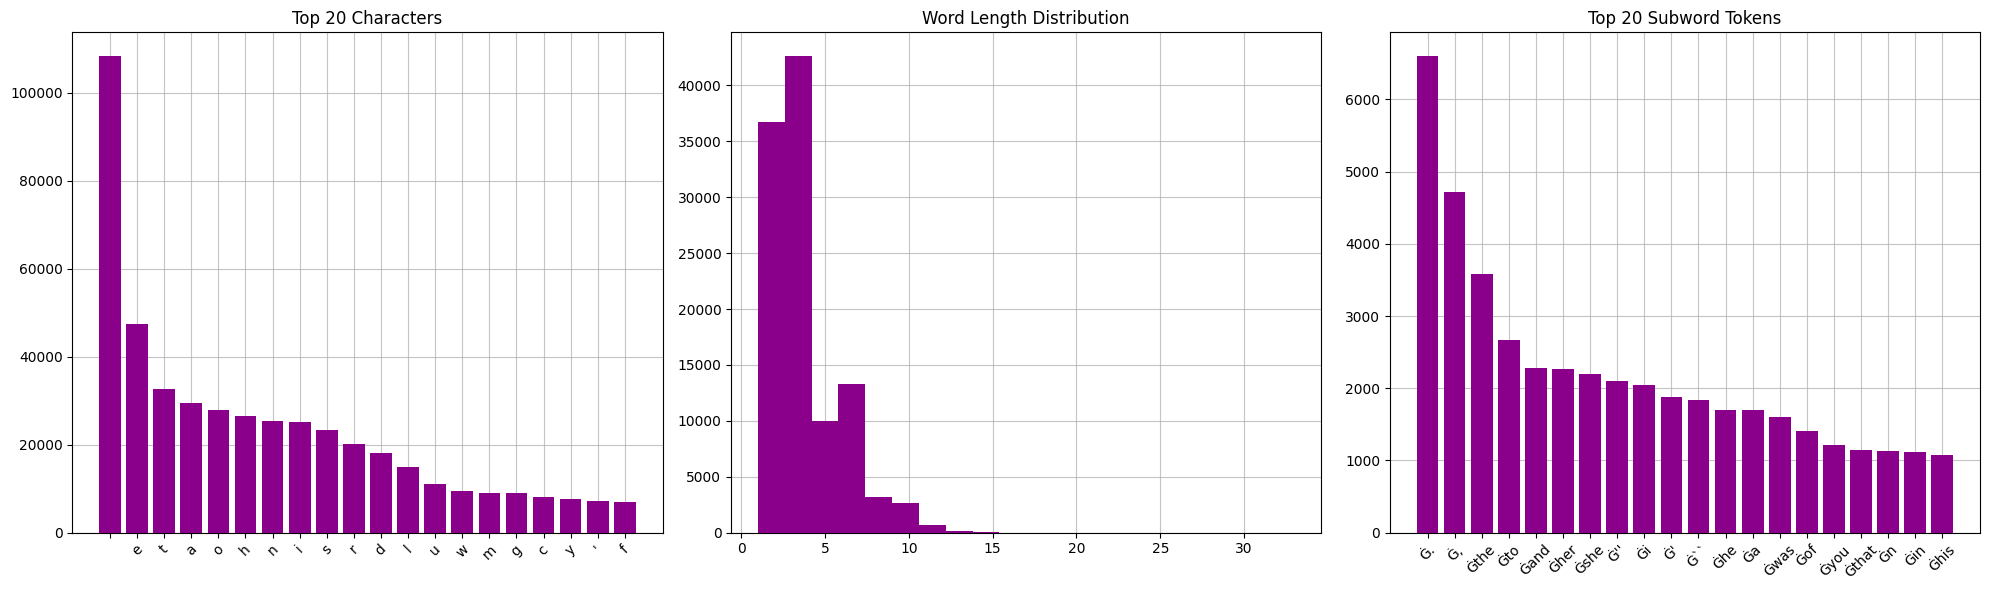

Unique characters: 51
Unique words: 7829
Unique subword tokens: 7757

Most common words: [('.', 6590), (',', 4714), ('the', 3610), ('to', 2671), ('she', 2306), ('and', 2292), ('her', 2275), ('i', 2119), ("''", 2102), ('``', 2070)]


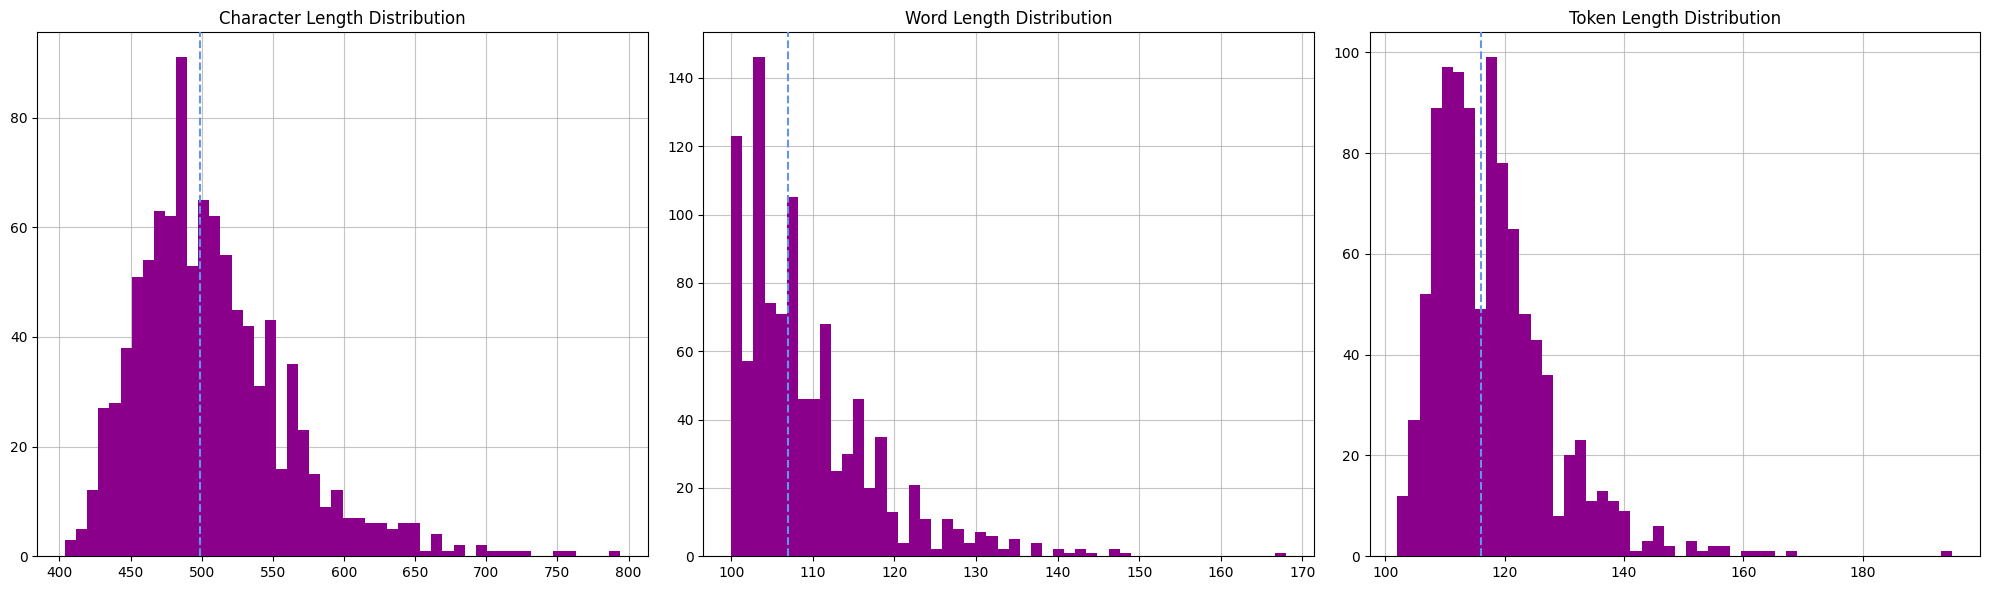


Sequence Length Statistics:
Character lengths - Mean: 507.6, Median: 499.0, Max: 794
Word lengths - Mean: 109.4, Median: 107.0, Max: 168
Token lengths - Mean: 118.0, Median: 116.0, Max: 195


In [17]:
char_counter, word_counter, token_counter = analyze_tokens(reconstructed_dataset)
length_stats = analyze_sequences(reconstructed_dataset)

In [18]:
def analyze_patterns(dataset, sample_size=1000, n_patterns=10):
    """Analyze common patterns in text"""
    texts = np.random.choice(dataset['text'], min(sample_size, len(dataset)))

    # Starting and ending patterns
    starters = []
    enders = []

    for text in texts:
        sentences = text.split('.')
        for sent in sentences:
            if len(sent.strip()) > 10:  # Filter meaningful sentences
                starters.append(' '.join(sent.strip().split()[:3]))  # First 3 words
                enders.append(' '.join(sent.strip().split()[-3:]))   # Last 3 words

    # Count patterns
    starter_patterns = Counter(starters).most_common(n_patterns)
    ender_patterns = Counter(enders).most_common(n_patterns)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot start patterns
    starter_df = pd.DataFrame(starter_patterns, columns=['pattern', 'count'])
    axes[0].grid(alpha=0.75, zorder=0)
    axes[0].bar(range(len(starter_df)), starter_df['count'], color='darkmagenta', zorder=3)
    axes[0].set_xticks(range(len(starter_df)))
    axes[0].set_xticklabels(starter_df['pattern'], rotation=45, ha='right')
    axes[0].set_title('Common Starting Patterns')

    # Plot end patterns
    ender_df = pd.DataFrame(ender_patterns, columns=['pattern', 'count'])
    axes[1].grid(alpha=0.75, zorder=0)
    axes[1].bar(range(len(ender_df)), ender_df['count'], color='darkmagenta', zorder=3)
    axes[1].set_xticks(range(len(ender_df)))
    axes[1].set_xticklabels(ender_df['pattern'], rotation=45, ha='right')
    axes[1].set_title('Common Ending Patterns')

    plt.tight_layout()
    plt.show()

    return starter_df, ender_df

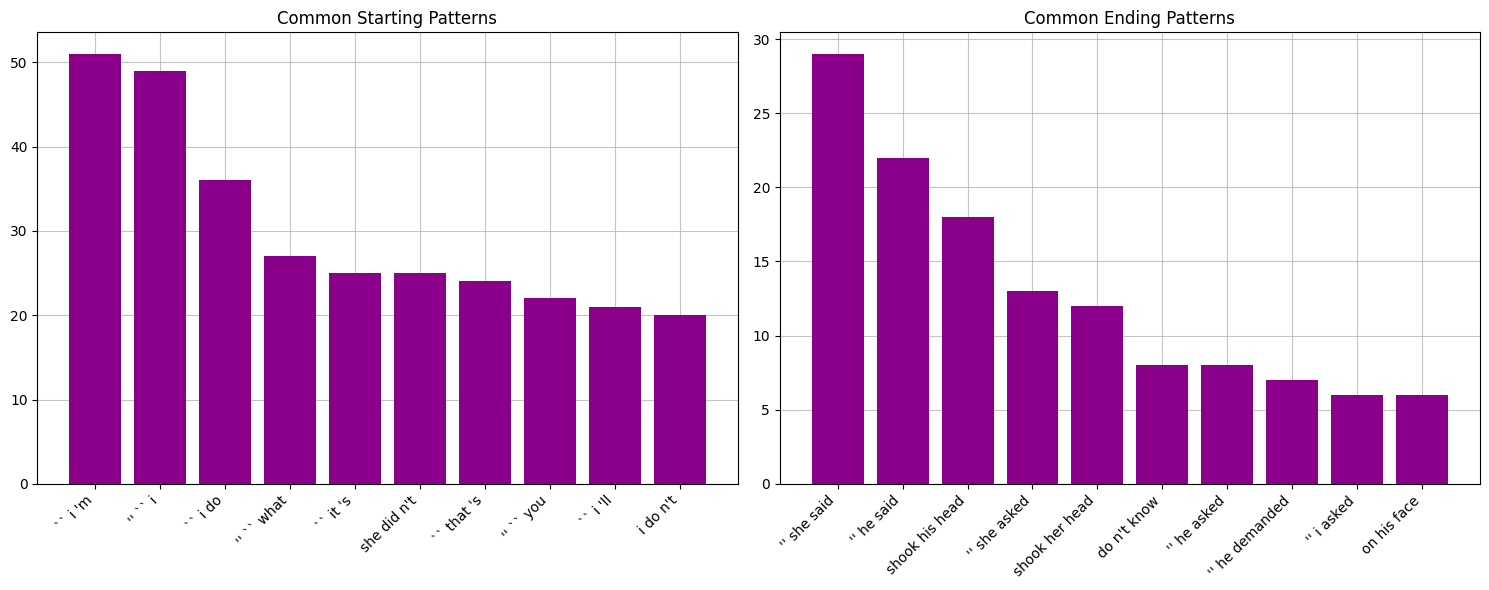

In [19]:
# Pattern analysis
starters, enders = analyze_patterns(reconstructed_dataset)

In [20]:
from string import ascii_letters, digits, punctuation, whitespace

def check_data_quality(dataset, sample_size=100):
    """Check dataset for potential quality issues"""
    sample = dataset.shuffle(seed=42).select(range(min(sample_size, len(dataset))))

    issues = {
        'empty_texts': 0,
        'very_short_texts': 0,  # < 100 words
        'unusual_chars': 0,
        'potential_code': 0
    }

    for text in sample['text']:
        if not text.strip():
            issues['empty_texts'] += 1
        if len(text.split()) < 100:
            issues['very_short_texts'] += 1
        if len(set(text) & set('{[]}#$@%^*')) > 5:  # Check for code-like characters
            issues['potential_code'] += 1
        if len(set(text) - set(ascii_letters + digits + punctuation + whitespace)) > 0:
            issues['unusual_chars'] += 1

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.grid(alpha=0.75, zorder=0)
    plt.bar(issues.keys(),
            [count/sample_size*100 for count in issues.values()],
            color='darkmagenta',
            zorder=3)
    plt.xticks(rotation=45)
    plt.ylabel('Percentage of Sample')
    plt.title('Data Quality Issues')
    plt.tight_layout()
    plt.show()

    print("\nPotential Data Quality Issues (sample):")
    for issue, count in issues.items():
        print(f"{issue}: {count} ({count/sample_size*100:.1f}%)")

    return issues

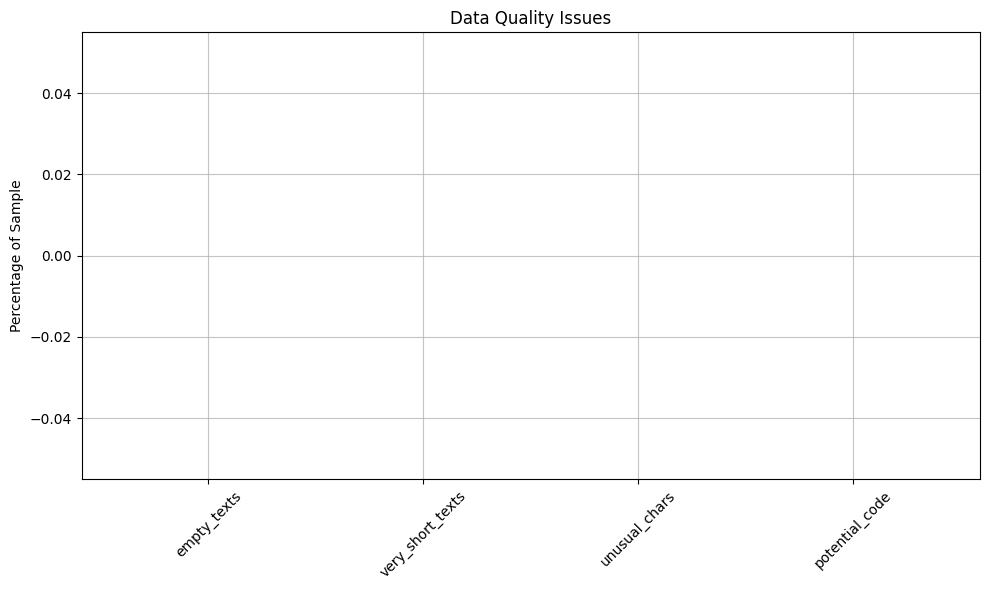


Potential Data Quality Issues (sample):
empty_texts: 0 (0.0%)
very_short_texts: 0 (0.0%)
unusual_chars: 0 (0.0%)
potential_code: 0 (0.0%)


In [21]:
quality_issues = check_data_quality(reconstructed_dataset)

In [22]:
# Word frequency analysis
from collections import Counter

def analyze_word_frequencies(dataset, sample_size=1000, top_n=20):
    sample = dataset.shuffle(seed=42).select(range(min(sample_size, len(dataset))))

    word_freq = Counter()
    for text in sample['text']:
        words = text.lower().split()
        word_freq.update(words)

    print(f"\nTop {top_n} most frequent words:")
    for word, count in word_freq.most_common(top_n):
        print(f"{word}: {count}")

analyze_word_frequencies(reconstructed_dataset)


Top 20 most frequent words:
.: 6593
,: 4651
the: 3558
to: 2692
her: 2335
she: 2329
and: 2313
i: 2110
'': 2095
``: 2064
he: 1800
a: 1689
was: 1530
of: 1440
you: 1303
that: 1112
his: 1110
in: 1075
n't: 1055
it: 1042


### Initial data cleaning

#### Cleaningtext function

In [ ]:
# Additional imports
import re
from bs4 import BeautifulSoup
import unicodedata
import string

def clean_text(text):
    """Main cleaning function"""
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Normalize unicode characters
    text = unicodedata.normalize('NFKD', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Standardize quotes and dashes
    text = re.sub(r'[''´`]', "'", text)
    text = re.sub(r'["""]', '"', text)
    text = re.sub(r'[‐‑‒–—―]', '-', text)

    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s.,!?\'\"()-]', ' ', text)

    # Fix spacing around punctuation
    text = re.sub(r'\s+([.,!?])', r'\1', text)

    return text.strip()

#### Process the dataset in chunks

In [ ]:
# Process dataset in chunks
def process_dataset_chunk(dataset, start_idx, end_idx):
    """Process a subset of the dataset"""
    texts = dataset[start_idx:end_idx]['text']
    cleaned_texts = [clean_text(text) for text in texts]
    return cleaned_texts

def clean_dataset(dataset, chunk_size=100):
    """Clean entire dataset in chunks"""
    cleaned_texts = []
    for i in range(0, len(dataset), chunk_size):
        end_idx = min(i + chunk_size, len(dataset))
        chunk_cleaned = process_dataset_chunk(dataset, i, end_idx)
        cleaned_texts.extend(chunk_cleaned)

        # Progress update
        if (i // chunk_size) % 10 == 0:
            print(f"Processed {i}/{len(dataset)} texts")

    return cleaned_texts

#### Create cleaned datasets(Debug as well)

In [ ]:
def debug_cleaning_process(dataset, chunk_size=50):
    """Debug version with more detailed analysis"""
    cleaned_texts = []
    length_distribution = []

    for i in range(0, len(dataset), chunk_size):
        end_idx = min(i + chunk_size, len(dataset))
        chunk = dataset.select(range(i, end_idx))

        for item in chunk:
            cleaned_text = clean_text(item['text'])
            text_length = len(cleaned_text.split())
            length_distribution.append(text_length)

            # Lower minimum word requirement for testing
            if text_length >= 10:  # Changed from 50 to 10 temporarily
                cleaned_texts.append(cleaned_text)

    print(f"\nText length statistics:")
    print(f"Average length: {np.mean(length_distribution):.1f} words")
    print(f"Max length: {max(length_distribution)} words")
    print(f"Min length: {min(length_distribution)} words")

    return cleaned_texts

def create_cleaned_dataset(dataset):
    """Create new dataset with cleaned texts"""
    cleaned_texts = debug_cleaning_process(dataset)

    # Create new dataset using from_dict
    from datasets import Dataset
    cleaned_dataset = Dataset.from_dict({'text': cleaned_texts})

    print(f"Original texts: {len(dataset)}")
    print(f"Cleaned texts: {len(cleaned_texts)}")
    return cleaned_dataset

#### Validation check and running the cleaning process

In [ ]:
# Validation check
def validate_cleaning(original_dataset, cleaned_dataset, num_samples=5):
    """Compare original and cleaned texts"""
    indices = range(min(num_samples, len(cleaned_dataset)))

    for idx in indices:
        print("\nOriginal:")
        print(original_dataset[int(idx)]['text'][:200])
        print("\nCleaned:")
        print(cleaned_dataset[int(idx)]['text'][:200])
        print("-" * 80)

In [ ]:
# Run the cleaning process
cleaned_dataset = create_cleaned_dataset(reconstructed_dataset)
validate_cleaning(reconstructed_dataset, cleaned_dataset)

### Text analysis and statistics (even more EDA)

#### Length distribution analysis

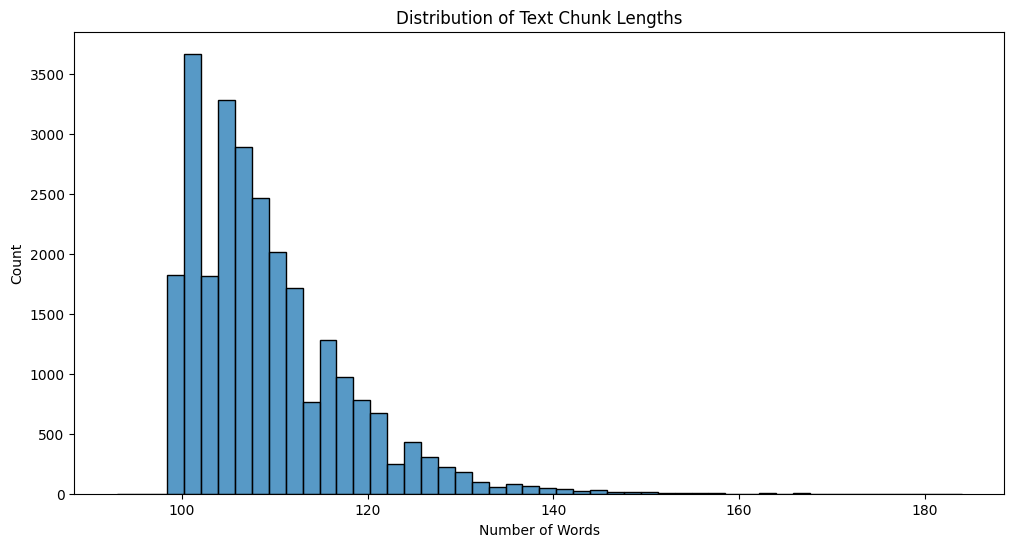


Word Count Percentiles:
25th: 103
50th (median): 107
75th: 113
90th: 120
95th: 125


In [28]:
# Additional imports
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import string

# Length distribution analysis
def analyze_length_distribution(dataset):
    lengths = [len(text.split()) for text in dataset['text']]

    plt.figure(figsize=(12, 6))
    sns.histplot(lengths, bins=50)
    plt.title('Distribution of Text Chunk Lengths')
    plt.xlabel('Number of Words')
    plt.ylabel('Count')
    plt.show()

    percentiles = np.percentile(lengths, [25, 50, 75, 90, 95])
    print("\nWord Count Percentiles:")
    print(f"25th: {percentiles[0]:.0f}")
    print(f"50th (median): {percentiles[1]:.0f}")
    print(f"75th: {percentiles[2]:.0f}")
    print(f"90th: {percentiles[3]:.0f}")
    print(f"95th: {percentiles[4]:.0f}")

analyze_length_distribution(reconstructed_dataset)

#### Vocabulary analysis

In [29]:
# Vocabulary analysis
def analyze_vocabulary(dataset, top_n=50):
    # Collect all words
    words = []
    for text in dataset['text']:
        words.extend(text.lower().split())

    # Count frequencies
    word_freq = Counter(words)

    print(f"Total unique words: {len(word_freq):,}")
    print(f"\nTop {top_n} most common words:")
    for word, count in word_freq.most_common(top_n):
        print(f"{word}: {count:,}")

    return word_freq

word_frequencies = analyze_vocabulary(reconstructed_dataset)

Total unique words: 31,406

Top 50 most common words:
.: 172,608
,: 122,976
the: 93,179
to: 70,436
she: 60,556
her: 60,477
and: 60,313
'': 55,684
i: 54,675
``: 54,512
he: 46,950
a: 43,500
was: 40,081
of: 36,970
you: 32,492
his: 30,058
in: 28,805
that: 28,664
n't: 26,555
it: 26,355
?: 23,129
with: 18,086
's: 18,078
had: 17,718
as: 17,354
my: 17,063
for: 16,580
him: 16,068
but: 15,990
on: 15,780
at: 14,750
'd: 14,728
me: 13,838
up: 11,800
out: 11,401
what: 11,052
do: 11,017
be: 10,534
could: 10,436
did: 10,312
said: 10,184
so: 9,778
would: 9,540
have: 9,135
this: 9,114
back: 8,946
when: 8,363
just: 8,355
all: 8,138
not: 8,059


#### Plot common word distributions

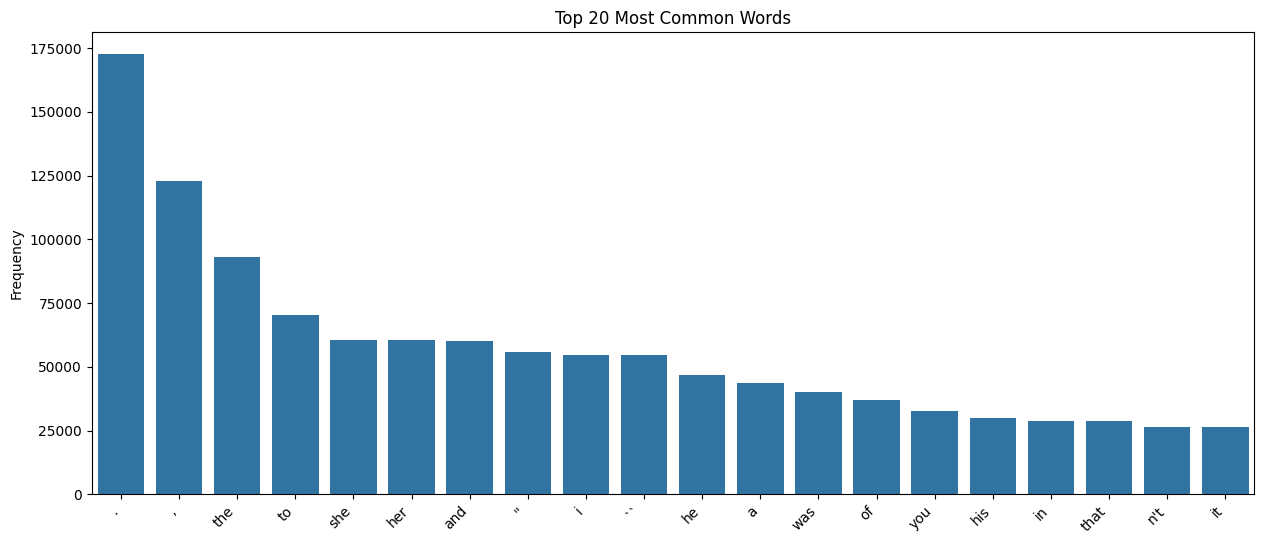

In [30]:
# Plot common words distribution
def plot_word_distribution(word_freq, top_n=20):
    words, counts = zip(*word_freq.most_common(top_n))

    plt.figure(figsize=(15, 6))
    sns.barplot(x=list(words), y=list(counts))
    plt.title(f'Top {top_n} Most Common Words')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Frequency')
    plt.show()

plot_word_distribution(word_frequencies)

#### Sentence structure analysis

In [31]:
# Cell 4.5: Download required NLTK data
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [32]:
# Cell 5: Sentence structure analysis
def analyze_sentence_structure(dataset, sample_size=1000):
    from nltk.tokenize import sent_tokenize
    import nltk
    nltk.download('punkt')

    # Sample texts to avoid memory issues
    sample_texts = dataset.shuffle(seed=42).select(range(sample_size))['text']

    sentences_per_chunk = []
    words_per_sentence = []

    for text in sample_texts:
        sentences = sent_tokenize(text)
        sentences_per_chunk.append(len(sentences))

        for sentence in sentences:
            words_per_sentence.append(len(sentence.split()))

    print("\nSentence Structure Analysis:")
    print(f"Average sentences per chunk: {np.mean(sentences_per_chunk):.1f}")
    print(f"Average words per sentence: {np.mean(words_per_sentence):.1f}")

    return sentences_per_chunk, words_per_sentence

sent_per_chunk, words_per_sent = analyze_sentence_structure(reconstructed_dataset)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Sentence Structure Analysis:
Average sentences per chunk: 7.7
Average words per sentence: 14.2


### Tokenizer setup

#### Tokenizer libraries

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json

#### Configure tokenizer parameters

In [39]:
VOCAB_SIZE = 8000  # Based on our vocabulary analysis
MAX_SEQUENCE_LENGTH = 128  # Based on our chunk lengths
PADDING_TYPE = 'post'
TRUNCATING_TYPE = 'post'
OOV_TOKEN = '<OOV>'  # Out of vocabulary token

# Special tokens
START_TOKEN = '<START>'
END_TOKEN = '<END>'
PAD_TOKEN = '<PAD>'

#### Prepare texts fot tokenizer training

In [40]:
def prepare_texts_for_tokenizer(dataset):
    # Add special tokens to texts
    texts = [f"{START_TOKEN} {text} {END_TOKEN}" for text in dataset['text']]
    return texts

# Prepare texts
tokenizer_texts = prepare_texts_for_tokenizer(reconstructed_dataset)
print(f"Prepared {len(tokenizer_texts)} texts for tokenizer training")

Prepared 119 texts for tokenizer training


#### Train(and save) the tokenizer

In [41]:
# Cell 2: Updated tokenizer functions
def train_tokenizer(texts):
    tokenizer = Tokenizer(
        num_words=VOCAB_SIZE,
        oov_token=OOV_TOKEN,
        filters='',
        lower=True
    )

    tokenizer.fit_on_texts(texts)

    # Add special tokens if not in vocabulary
    for token in [START_TOKEN, END_TOKEN, PAD_TOKEN]:
        if token not in tokenizer.word_index:
            tokenizer.word_index[token] = len(tokenizer.word_index) + 1
            tokenizer.index_word[tokenizer.word_index[token]] = token

    return tokenizer

def save_tokenizer(tokenizer, save_dir='tokenizer_data'):
    """Save tokenizer configuration and vocabulary"""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Save word index
    with open(f'{save_dir}/word_index.json', 'w') as f:
        json.dump(tokenizer.word_index, f)

    # Save index word
    with open(f'{save_dir}/index_word.json', 'w') as f:
        json.dump(tokenizer.index_word, f)

    # Save config
    config = {
        'vocab_size': VOCAB_SIZE,
        'max_length': MAX_SEQUENCE_LENGTH,
        'special_tokens': {
            'start': START_TOKEN,
            'end': END_TOKEN,
            'pad': PAD_TOKEN,
            'oov': OOV_TOKEN
        }
    }
    with open(f'{save_dir}/config.json', 'w') as f:
        json.dump(config, f)

In [42]:
# Cell 3: Train and save tokenizer
tokenizer = train_tokenizer(tokenizer_texts)
print(f"Vocabulary size: {len(tokenizer.word_index)}")
save_tokenizer(tokenizer, save_dir='/content/drive/MyDrive/your_project/tokenizer_data')

Vocabulary size: 1921


#### Test tokenizer and create sequences

In [ ]:
def tokenize_and_pad(texts, tokenizer):
    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(texts)

    # Pad sequences
    padded_sequences = pad_sequences(
        sequences,
        maxlen=MAX_SEQUENCE_LENGTH,
        padding=PADDING_TYPE,
        truncating=TRUNCATING_TYPE
    )

    print("Sequence shape:", padded_sequences.shape)
    return padded_sequences

# Create sequences
padded_sequences = tokenize_and_pad(tokenizer_texts, tokenizer)

# Test on a sample text
sample_idx = 0
print("\nTokenization Test:")
print("Original:", tokenizer_texts[sample_idx][:100])
print("Tokenized:", padded_sequences[sample_idx][:20])

#### Saving the tokenizer config

In [ ]:
def save_tokenizer(tokenizer, filename='tokenizer.json'):
    tokenizer_config = {
        'word_index': tokenizer.word_index,
        'index_word': tokenizer.index_word,
        'vocab_size': VOCAB_SIZE,
        'max_sequence_length': MAX_SEQUENCE_LENGTH,
        'special_tokens': {
            'start': START_TOKEN,
            'end': END_TOKEN,
            'pad': PAD_TOKEN,
            'oov': OOV_TOKEN
        }
    }

    with open(filename, 'w') as f:
        json.dump(tokenizer_config, f)
    print(f"Tokenizer saved to {filename}")

save_tokenizer(tokenizer)

### Data processing and storage

#### Generating input target pairs

In [39]:
def create_training_pairs(sequences, window_size=35):
    inputs, targets = [], []
    for sequence in sequences:
        for i in range(len(sequence) - window_size):
            inputs.append(sequence[i:i+window_size])
            targets.append(sequence[i+1:i+window_size+1])
    return np.array(inputs), np.array(targets)

window_size = 35  # For training context
X, y = create_training_pairs(padded_sequences)
print(f"Training pairs shape: {X.shape}, {y.shape}")

Training pairs shape: (2423766, 35), (2423766, 35)


#### Creating TF dataset

In [40]:
import tensorflow as tf
def create_tf_dataset(X, y, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(10000)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

BATCH_SIZE = 64
train_dataset = create_tf_dataset(X, y, BATCH_SIZE)

#### Saving the processed data

In [41]:
def save_processed_data(X, y, filename='processed_data.npz'):
    np.savez_compressed(
        filename,
        inputs=X,
        targets=y
    )
    print(f"Data saved to {filename}")

save_processed_data(X, y)

Data saved to processed_data.npz


### Training data pipeline setup

#### Pipeline configuration

In [42]:
AUTOTUNE = tf.data.AUTOTUNE
TRAINING_SPLIT = 0.9
VALIDATION_SPLIT = 0.1

def configure_dataset_pipeline(total_samples):
    train_size = int(total_samples * TRAINING_SPLIT)

    train_indices = np.random.choice(total_samples, train_size, replace=False)
    val_indices = np.setdiff1d(np.arange(total_samples), train_indices)

    return train_indices, val_indices

#### Creating training/valdation splits

In [43]:
# Using the function to create splis
train_idx, val_idx = configure_dataset_pipeline(len(X))

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Training samples: 2181389
Validation samples: 242377


#### Creating final datasets

In [44]:
def create_final_datasets(X_train, y_train, X_val, y_val, batch_size=64):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(10000)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
    train_dataset = train_dataset.prefetch(AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(batch_size, drop_remainder=True)
    val_dataset = val_dataset.prefetch(AUTOTUNE)

    return train_dataset, val_dataset

train_dataset, val_dataset = create_final_datasets(X_train, y_train, X_val, y_val)

#### Test pipeline

In [45]:
def test_pipeline(dataset):
    for batch in dataset.take(1):
        print(f"Input shape: {batch[0].shape}")
        print(f"Target shape: {batch[1].shape}")
        break

print("Testing training dataset:")
test_pipeline(train_dataset)
print("\nTesting validation dataset:")
test_pipeline(val_dataset)

Testing training dataset:
Input shape: (64, 35)
Target shape: (64, 35)

Testing validation dataset:
Input shape: (64, 35)
Target shape: (64, 35)


## LLM Model building and training

### Model architecture design

#### Model configuration

In [54]:
class ModelConfig:
   def __init__(self):
       # Architecture
       self.n_layers = 6
       self.d_model = 256
       self.n_heads = 4
       self.d_ff = 1024

       # Training
       self.dropout = 0.1
       self.vocab_size = VOCAB_SIZE
       self.max_length = MAX_SEQUENCE_LENGTH

config = ModelConfig()

#### Positional encoding

In [55]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(max_position, d_model):
    angle_rads = get_angles(np.arange(max_position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

#### Attention mechanism

In [56]:
def scaled_dot_product_attention(q, k, v, mask=None):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

#### Multi-head attention

In [57]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % num_heads == 0
        self.depth = d_model // num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention,
                                    (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)
        return output, attention_weights

#### Feed forward network

In [58]:
def point_wise_feed_forward_network(d_model, d_ff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(d_ff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

#### Encoder layer (and evaluatiing the design architecture)

In [59]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout_rate=0.1):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, d_ff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training=True, mask=None):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

Test the architecture componenets before proceeding

In [60]:
# Test Cell: Verify architecture components
def test_architecture():
    # Test positional encoding
    pos_encoding = positional_encoding(50, config.d_model)
    print("Positional encoding shape:", pos_encoding.shape)

    # Test attention mechanism
    test_k = tf.random.uniform((2, 4, 8))  # (batch_size, seq_len, d_model)
    test_v = tf.random.uniform((2, 4, 8))
    test_q = tf.random.uniform((2, 4, 8))

    temp_out, temp_attn = scaled_dot_product_attention(test_q, test_k, test_v)
    print("\nAttention output shape:", temp_out.shape)

    # Test multi-head attention
    temp_mha = MultiHeadAttention(d_model=8, num_heads=2)
    out, attn = temp_mha(test_v, test_k, test_q)
    print("Multi-head attention output shape:", out.shape)

    # Test encoder layer
    sample_encoder_layer = EncoderLayer(
        d_model=config.d_model,
        num_heads=config.n_heads,
        d_ff=config.d_ff
    )
    sample_input = tf.random.uniform((2, 4, config.d_model))
    output = sample_encoder_layer(sample_input)
    print("\nEncoder layer output shape:", output.shape)

test_architecture()

Positional encoding shape: (1, 50, 256)

Attention output shape: (2, 4, 8)
Multi-head attention output shape: (2, 4, 8)

Encoder layer output shape: (2, 4, 256)


### Model implementation

#### Complete model class

In [61]:
import tensorflow as tf
class SmallLLM(tf.keras.Model):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = tf.keras.layers.Embedding(config.vocab_size, config.d_model)
        self.pos_encoding = positional_encoding(config.max_length, config.d_model)

        self.encoder_layers = [
            EncoderLayer(
                config.d_model,
                config.n_heads,
                config.d_ff,
                config.dropout
            ) for _ in range(config.n_layers)
        ]

        self.dropout = tf.keras.layers.Dropout(config.dropout)
        self.final_layer = tf.keras.layers.Dense(config.vocab_size)

    def call(self, x, training=True):
        seq_len = tf.shape(x)[1]

        # Embedding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.config.d_model, tf.float32))

        # Add positional encoding
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        # Encoder layers
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, training=training)

        # Final layer
        x = self.final_layer(x)
        return x

#### Test model

In [54]:
def test_model():
    model = SmallLLM(config)
    test_input = tf.random.uniform((2, 35))  # Batch size 2, sequence length 35
    test_output = model(test_input)
    print("Model output shape:", test_output.shape)
    print("Total parameters:", model.count_params())

    # Test forward pass
    sample_batch = next(iter(train_dataset))
    output = model(sample_batch[0])
    print("\nOutput on real batch shape:", output.shape)

test_model()

Model output shape: (2, 35, 8000)
Total parameters: 8842560

Output on real batch shape: (64, 35, 8000)


### Training setup

#### Learning rate schedule

In [62]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

#### Loss and metrics

In [56]:
# (Updated) Loss and Metrics
def loss_function(real, pred):
    real = tf.cast(real, tf.int32)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy_function(real, pred):
    predictions = tf.cast(tf.argmax(pred, axis=2), tf.int32)
    real = tf.cast(real, tf.int32)
    accuracies = tf.equal(real, predictions)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    return tf.reduce_mean(tf.cast(accuracies, dtype=tf.float32))

#### Training configuration

In [57]:
learning_rate = CustomSchedule(config.d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')

#### Test setup

In [58]:
# Test Setup
def test_training_setup():
    model = SmallLLM(config)
    sample_batch = next(iter(train_dataset))
    inputs = tf.cast(sample_batch[0], tf.int32)
    targets = tf.cast(sample_batch[1], tf.int32)

    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_function(targets, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    accuracy = accuracy_function(targets, predictions)

    print("Test batch loss:", float(loss))
    print("Test batch accuracy:", float(accuracy))
    print("Learning rate:", float(learning_rate(1)))

test_training_setup()

Test batch loss: 8.575751304626465
Test batch accuracy: 0.0
Learning rate: 2.470529523179721e-07


Doing some verfication before moving on.

In [59]:
# Cell 1: Update Training Setup
def create_model_and_optimizer():
    model = SmallLLM(config)
    optimizer = tf.keras.optimizers.Adam(CustomSchedule(config.d_model))
    return model, optimizer

In [60]:
# Cell 2: Update Training Step (without @tf.function for now)
def train_step(model, optimizer, inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_function(targets, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(targets, predictions))
    return loss

def validate_step(model, inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_function(targets, predictions)
    acc = accuracy_function(targets, predictions)
    return loss, acc

In [61]:
# Cell 3: Update Test Steps
def test_steps():
    model, optimizer = create_model_and_optimizer()
    batch = next(iter(train_dataset))
    inputs = tf.cast(batch[0], tf.int32)
    targets = tf.cast(batch[1], tf.int32)

    print("Testing train step...")
    loss = train_step(model, optimizer, inputs, targets)
    print(f"Train Loss: {train_loss.result():.4f}")
    print(f"Train Accuracy: {train_accuracy.result():.4f}")

    print("\nTesting validation step...")
    validate_step(model, inputs, targets)
    print(f"Val Loss: {val_loss.result():.4f}")
    print(f"Val Accuracy: {val_accuracy.result():.4f}")

test_steps()

Testing train step...
Train Loss: 8.6480
Train Accuracy: 0.0000

Testing validation step...
Val Loss: 0.0000
Val Accuracy: 0.0000


### Training process

#### Implementing the training loop

In [ ]:
# Cell 1: Simplified metrics
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

In [ ]:
# Cell 1: Update training functions (remove @tf.function)
def train_step(model, optimizer, inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_function(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    acc = accuracy_function(targets, predictions)
    return loss, acc

def validate_step(model, inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_function(targets, predictions)
    acc = accuracy_function(targets, predictions)
    return loss, acc

#### Training loop

In [ ]:
# Creating a test set to see if training can be done
def create_test_datasets(train_size=0.1):
   # Take fraction of data for testing
   small_train = train_dataset.take(int(len(train_dataset) * train_size))
   small_val = val_dataset.take(int(len(val_dataset) * train_size))
   return small_train, small_val

In [ ]:
"""from tqdm import tqdm
# Updated training function
def train_model(epochs=2, test_mode=True, train_size=0.1):
   if test_mode:
       train_data, val_data = create_test_datasets(train_size)
   else:
       train_data, val_data = train_dataset, val_dataset

   model, optimizer = create_model_and_optimizer()
   best_val_loss = float('inf')
   patience = 3
   patience_counter = 0

   for epoch in range(epochs):
       epoch_train_loss = []
       epoch_train_acc = []
       epoch_val_loss = []
       epoch_val_acc = []

       # Training with progress bar
       train_bar = tqdm(train_data, desc=f'Epoch {epoch+1}/{epochs} [Train]')
       for batch in train_bar:
           loss, acc = train_step(model, optimizer,
                                tf.cast(batch[0], tf.int32),
                                tf.cast(batch[1], tf.int32))
           epoch_train_loss.append(float(loss))
           epoch_train_acc.append(float(acc))
           train_bar.set_postfix({'loss': f'{np.mean(epoch_train_loss):.4f}',
                                'acc': f'{np.mean(epoch_train_acc):.4f}'})

       # Validation with progress bar
       val_bar = tqdm(val_data, desc=f'Epoch {epoch+1}/{epochs} [Val]')
       for batch in val_bar:
           loss, acc = validate_step(model,
                                   tf.cast(batch[0], tf.int32),
                                   tf.cast(batch[1], tf.int32))
           epoch_val_loss.append(float(loss))
           epoch_val_acc.append(float(acc))
           val_bar.set_postfix({'loss': f'{np.mean(epoch_val_loss):.4f}',
                              'acc': f'{np.mean(epoch_val_acc):.4f}'})

       # Calculate epoch metrics
       avg_train_loss = np.mean(epoch_train_loss)
       avg_train_acc = np.mean(epoch_train_acc)
       avg_val_loss = np.mean(epoch_val_loss)
       avg_val_acc = np.mean(epoch_val_acc)

       train_loss.append(avg_train_loss)
       train_accuracy.append(avg_train_acc)
       val_loss.append(avg_val_loss)
       val_accuracy.append(avg_val_acc)

       print(f'\nEpoch {epoch + 1} Summary:')
       print(f'Loss: {avg_train_loss:.4f}')
       print(f'Accuracy: {avg_train_acc:.4f}')
       print(f'Val Loss: {avg_val_loss:.4f}')
       print(f'Val Accuracy: {avg_val_acc:.4f}\n')

       if avg_val_loss < best_val_loss:
           best_val_loss = avg_val_loss
           patience_counter = 0
       else:
           patience_counter += 1
           if patience_counter >= patience:
               print("Early stopping triggered")
               break

   return model

# Test run with 10% data
model = train_model(epochs=2, test_mode=True, train_size=0.1)"""

'from tqdm import tqdm\n# Updated training function\ndef train_model(epochs=2, test_mode=True, train_size=0.1):\n   if test_mode:\n       train_data, val_data = create_test_datasets(train_size)\n   else:\n       train_data, val_data = train_dataset, val_dataset\n\n   model, optimizer = create_model_and_optimizer()\n   best_val_loss = float(\'inf\')\n   patience = 3\n   patience_counter = 0\n\n   for epoch in range(epochs):\n       epoch_train_loss = []\n       epoch_train_acc = []\n       epoch_val_loss = []\n       epoch_val_acc = []\n\n       # Training with progress bar\n       train_bar = tqdm(train_data, desc=f\'Epoch {epoch+1}/{epochs} [Train]\')\n       for batch in train_bar:\n           loss, acc = train_step(model, optimizer,\n                                tf.cast(batch[0], tf.int32),\n                                tf.cast(batch[1], tf.int32))\n           epoch_train_loss.append(float(loss))\n           epoch_train_acc.append(float(acc))\n           train_bar.set_postfix(

In [ ]:
# New training code with checkpointing
from tqdm import tqdm
import os

def train_model(epochs=2, test_mode=True, train_size=0.1, checkpoint_dir = '/content/drive/MyDrive/your_project/checkpoints'):
   # Create checkpoint directory
   if not os.path.exists(checkpoint_dir):
       os.makedirs(checkpoint_dir)

   if test_mode:
       train_data, val_data = create_test_datasets(train_size)
   else:
       train_data, val_data = train_dataset, val_dataset

   model, optimizer = create_model_and_optimizer()

   # Setup checkpoint
   ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
   manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=3)

   best_val_loss = float('inf')
   patience = 3
   patience_counter = 0

   for epoch in range(epochs):
       epoch_train_loss = []
       epoch_train_acc = []
       epoch_val_loss = []
       epoch_val_acc = []

       # Training with progress bar
       train_bar = tqdm(train_data, desc=f'Epoch {epoch+1}/{epochs} [Train]')
       for batch in train_bar:
           loss, acc = train_step(model, optimizer,
                                tf.cast(batch[0], tf.int32),
                                tf.cast(batch[1], tf.int32))
           epoch_train_loss.append(float(loss))
           epoch_train_acc.append(float(acc))
           train_bar.set_postfix({'loss': f'{np.mean(epoch_train_loss):.4f}',
                                'acc': f'{np.mean(epoch_train_acc):.4f}'})

       # Validation with progress bar
       val_bar = tqdm(val_data, desc=f'Epoch {epoch+1}/{epochs} [Val]')
       for batch in val_bar:
           loss, acc = validate_step(model,
                                   tf.cast(batch[0], tf.int32),
                                   tf.cast(batch[1], tf.int32))
           epoch_val_loss.append(float(loss))
           epoch_val_acc.append(float(acc))
           val_bar.set_postfix({'loss': f'{np.mean(epoch_val_loss):.4f}',
                              'acc': f'{np.mean(epoch_val_acc):.4f}'})

       # Calculate epoch metrics
       avg_train_loss = np.mean(epoch_train_loss)
       avg_train_acc = np.mean(epoch_train_acc)
       avg_val_loss = np.mean(epoch_val_loss)
       avg_val_acc = np.mean(epoch_val_acc)

       train_loss.append(avg_train_loss)
       train_accuracy.append(avg_train_acc)
       val_loss.append(avg_val_loss)
       val_accuracy.append(avg_val_acc)

       print(f'\nEpoch {epoch + 1} Summary:')
       print(f'Loss: {avg_train_loss:.4f}')
       print(f'Accuracy: {avg_train_acc:.4f}')
       print(f'Val Loss: {avg_val_loss:.4f}')
       print(f'Val Accuracy: {avg_val_acc:.4f}\n')

       # Save checkpoint if validation loss improved
       if avg_val_loss < best_val_loss:
           best_val_loss = avg_val_loss
           patience_counter = 0
           save_path = manager.save()
           print(f"Saved checkpoint for epoch {epoch+1}: {save_path}")
       else:
           patience_counter += 1
           if patience_counter >= patience:
               print("Early stopping triggered")
               break

   return model


# Test run with 10% data
model = train_model(epochs=2, test_mode=True, train_size=0.1)

Epoch 1/2 [Val]: 100%|██████████| 378/378 [00:50<00:00,  7.48it/s, loss=0.1227, acc=0.9246]



Epoch 1 Summary:
Loss: 1.5243
Accuracy: 0.7423
Val Loss: 0.1227
Val Accuracy: 0.9246

Saved checkpoint for epoch 1: /content/drive/MyDrive/your_project/checkpoints/ckpt-1


Epoch 2/2 [Val]: 100%|██████████| 378/378 [01:21<00:00,  4.62it/s, loss=0.1136, acc=0.9255]



Epoch 2 Summary:
Loss: 0.1340
Accuracy: 0.9227
Val Loss: 0.1136
Val Accuracy: 0.9255

Saved checkpoint for epoch 2: /content/drive/MyDrive/your_project/checkpoints/ckpt-2


In [ ]:
# For full training later
#model = train_model(epochs=10, test_mode=False)

### Evaluation

#### Text generation function

In [ ]:
# Text Generation Function
def generate_text(model, seed_text, tokenizer, max_length=50):
    input_text = seed_text

    for _ in range(max_length):
        tokenized = tokenizer.texts_to_sequences([input_text])[0]
        padded = pad_sequences([tokenized], maxlen=35, padding='pre')

        predictions = model(padded)
        predicted_token = tf.argmax(predictions[0, -1]).numpy()

        predicted_word = tokenizer.index_word.get(predicted_token, '')

        if predicted_word == '<END>':
            break

        input_text += ' ' + predicted_word

    return input_text

#### Model evaluation metrics

In [ ]:
# Model Evaluation Metrics
def evaluate_model(model, val_dataset, num_samples=100):
    perplexity_scores = []
    generation_lengths = []

    # Calculate perplexity
    for batch in val_dataset.take(num_samples):
        loss = loss_function(batch[1], model(batch[0]))
        perplexity = tf.exp(loss)
        perplexity_scores.append(float(perplexity))

    # Generate sample texts
    sample_texts = []
    for text in val_dataset.take(5):
        seed = tokenizer.sequences_to_texts([text[0][0].numpy()])[0][:50]
        generated = generate_text(model, seed, tokenizer)
        sample_texts.append({
            'seed': seed,
            'generated': generated
        })

    return {
        'perplexity': np.mean(perplexity_scores),
        'samples': sample_texts
    }

#### Model saving

In [ ]:
# Model Saving
def save_trained_model(model, save_dir='trained_model'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    model.save_weights(f'{save_dir}/weights')

    # Save model configuration
    config_dict = {
        'n_layers': config.n_layers,
        'd_model': config.d_model,
        'n_heads': config.n_heads,
        'd_ff': config.d_ff,
        'dropout': config.dropout,
        'vocab_size': config.vocab_size,
        'max_length': config.max_length
    }

    with open(f'{save_dir}/config.json', 'w') as f:
        json.dump(config_dict, f)

In [ ]:
# Test evaluation
print("Testing model evaluation...")
eval_results = evaluate_model(model, val_dataset)

print(f"\nModel Perplexity: {eval_results['perplexity']:.2f}")
print("\nSample Generations:")
for i, sample in enumerate(eval_results['samples'], 1):
    print(f"\nSample {i}:")
    print(f"Seed: {sample['seed'][:50]}...")
    print(f"Generated: {sample['generated']}")

Testing model evaluation...

Model Perplexity: 1.12

Sample Generations:

Sample 1:
Seed: would be tearing around the living room , playing ...
Generated: would be tearing around the living room , playing  . `` are you . '' `` i 'm going to see you 're a <OOV> . '' he asked , trying to the door . `` i 'll be to see you 're a <OOV> . '' `` i 'll be to do you want to get to be

Sample 2:
Seed: to get mason into the car seat in her parents ' la...
Generated: to get mason into the car seat in her parents ' la . <end> was a <OOV> . <end> was a <OOV> . she was a <OOV> . <end> was a <OOV> . she was a <OOV> <OOV> . she 'd made to her . she was a <OOV> . she had to the <OOV> of the <OOV> . she was a

Sample 3:
Seed: bypassed everyone by turning right and heading dow...
Generated: bypassed everyone by turning right and heading dow . <end> was a <OOV> . <end> had to her . `` i 'm working to do . '' `` i 'm going to do . '' `` i do n't want to do you want to see you want to see you 're working . '

## Fine-tuning my model on the IMDB dataset

### Setup

#### Loading my model from *Gdrive*

In [63]:
"""# Cell 1: Model creation function
def create_model_and_optimizer():
    model = SmallLLM(config)
    optimizer = tf.keras.optimizers.Adam(CustomSchedule(config.d_model))
    return model, optimizer

def load_trained_model(checkpoint_dir='/content/drive/MyDrive/your_project/checkpoints'):
    model, optimizer = create_model_and_optimizer()
    ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
    manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=3)

    if manager.latest_checkpoint:
        ckpt.restore(manager.latest_checkpoint)
        print(f"Restored from {manager.latest_checkpoint}")
    else:
        print("No checkpoint found")
    return model

# First, load the saved model
model = load_trained_model(checkpoint_dir = '/content/drive/MyDrive/your_project/checkpoints')"""

Restored from /content/drive/MyDrive/your_project/checkpoints/ckpt-2


In [134]:
# new initialisation to troubleshoot
# Reinitialize model with explicit config check
model = SmallLLM(model.config)
dummy_input = tf.zeros((1, model.config.max_length), dtype=tf.int32)
_ = model(dummy_input)  # Build model
print("Embedding verified:", not np.any(np.isnan(model.embedding.get_weights()[0])))

# Restore weights from checkpoint
ckpt = tf.train.Checkpoint(model=model)
ckpt.restore(tf.train.latest_checkpoint('/content/drive/MyDrive/your_project/checkpoints'))

Embedding verified: True


#### Loading the tokenizer

In [135]:
# Cell: Load tokenizer for fine-tuning
def load_tokenizer_fortuning(load_dir='/content/drive/MyDrive/your_project/tokenizer_data'):
    with open(f'{load_dir}/word_index.json', 'r') as f:
        word_index = json.load(f)
    with open(f'{load_dir}/index_word.json', 'r') as f:
        index_word = json.load(f)
    return {'word_index': word_index, 'index_word': index_word}

tokenizer_fortuning = load_tokenizer_fortuning()

### Data preperation

#### Creating subset for fine-tuning

In [136]:
# Cell: Create fine-tuning subsets with conversion
def create_fine_tuning_subset(data, percentage=0.1):
    subset_size = int(len(data) * percentage)
    indices = np.random.choice(len(data), subset_size, replace=False)

    # Convert PyTorch tensors to numpy arrays first
    converted_data = []
    for i in indices:
        item = data[i]
        converted_data.append({
            'input_ids': item['input_ids'].numpy(),
            'labels': item['labels'].numpy()
        })
    return converted_data

def create_dataset(data, batch_size=32):
    return tf.data.Dataset.from_tensor_slices({
        'input_ids': [item['input_ids'] for item in data],
        'labels': [item['labels'] for item in data]
    }).batch(batch_size)

# Create fine-tuning subsets
train_subset_fromscratch = create_fine_tuning_subset(train_dataset)
test_subset_fromscratch = create_fine_tuning_subset(test_dataset)

# Create datasets
train_ds_fromscratch = create_dataset(train_subset_fromscratch)
test_ds_fromscratch = create_dataset(test_subset_fromscratch)

In [137]:
# Cell: Verify datasets
print("Dataset sizes:")
print(f"Train subset: {len(train_subset_fromscratch)}")
print(f"Test subset: {len(test_subset_fromscratch)}")

# Check first batch
for batch in train_ds_fromscratch.take(1):
   print("\nFirst batch shapes:")
   print(f"Input shape: {batch['input_ids'].shape}")
   print(f"Labels shape: {batch['labels'].shape}")
   print("\nValue ranges:")
   print(f"Input values range: {tf.reduce_min(batch['input_ids'])} to {tf.reduce_max(batch['input_ids'])}")
   print(f"Vocab size in model: {model.config.vocab_size}")

Dataset sizes:
Train subset: 10930
Test subset: 10631

First batch shapes:
Input shape: (32, 512)
Labels shape: (32, 128)

Value ranges:
Input values range: 0 to 50256
Vocab size in model: 8000


#### Token-mapping and dataset update

In [138]:
def safe_token_mapping(tokens):
    # Map tokens to valid vocab range
    mapped = tf.where(tokens < 0, 0, tokens)  # Handle negatives
    mapped = tf.where(mapped >= 8000, 7999, mapped)  # Handle out of vocab
    return tf.cast(mapped, tf.int32)

def create_dataset_with_token_mapping(data, batch_size=32):
    mapped_data = tf.data.Dataset.from_tensor_slices({
        'input_ids': [safe_token_mapping(item['input_ids'][:128]) for item in data],
        'labels': [safe_token_mapping(item['labels']) for item in data]
    }).batch(batch_size)
    return mapped_data

# Recreate datasets and try again
train_ds_fromscratch = create_dataset_with_token_mapping(train_subset_fromscratch)
test_ds_fromscratch = create_dataset_with_token_mapping(test_subset_fromscratch)

# Verify mapping
for batch in train_ds_fromscratch.take(1):
   print("After mapping:")
   print(f"Input values range: {tf.reduce_min(batch['input_ids'])} to {tf.reduce_max(batch['input_ids'])}")

After mapping:
Input values range: 0 to 7999


In [139]:
# Debug token ranges
for batch in train_ds_fromscratch.take(1):
    print("Input token range:", tf.reduce_min(batch['input_ids']), "to", tf.reduce_max(batch['input_ids']))
    unique_tokens = tf.unique(tf.reshape(batch['input_ids'], [-1]))
    print("Sample unique tokens:", unique_tokens.y[:10])

Input token range: tf.Tensor(0, shape=(), dtype=int32) to tf.Tensor(7999, shape=(), dtype=int32)
Sample unique tokens: tf.Tensor([  13  484 1826  416 2863  355 7999 6614  703  857], shape=(10,), dtype=int32)


In [140]:
print("Model config:", vars(model.config))
print("\nEmbedding weights shape:", model.embedding.weights[0].shape)

# Check input data
for batch in train_ds_fromscratch.take(1):
    print("\nInput token range:", tf.reduce_min(batch['input_ids']), "to", tf.reduce_max(batch['input_ids']))
    print("Unique tokens sample:", tf.unique(tf.reshape(batch['input_ids'][:1], [-1])).y[:5])

Model config: {'n_layers': 6, 'd_model': 256, 'n_heads': 4, 'd_ff': 1024, 'dropout': 0.1, 'vocab_size': 8000, 'max_length': 128}

Embedding weights shape: (8000, 256)

Input token range: tf.Tensor(0, shape=(), dtype=int32) to tf.Tensor(7999, shape=(), dtype=int32)
Unique tokens sample: tf.Tensor([  13  484 1826  416 2863], shape=(5,), dtype=int32)


### Fine-tuning setup

#### Fine-tuning configuration

In [141]:
# Cell 1: Fine-tuning configuration
class FineTuningConfig:
   def __init__(self):
       self.learning_rate = 1e-5
       self.num_epochs = 3
       self.batch_size = 32
       self.max_grad_norm = 1.0
       self.early_stopping_patience = 2

ft_config = FineTuningConfig()

#### Trainingin metrics

In [142]:
# Cell 2: Training metrics and steps
train_loss = tf.keras.metrics.Mean()
val_loss = tf.keras.metrics.Mean()

@tf.function
def train_step(inputs, labels):
    # Map tokens to valid range
    inputs = safe_token_mapping(inputs)
    labels = safe_token_mapping(labels)

    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions, from_logits=True)
        loss = tf.reduce_mean(loss)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, tf.exp(loss)

### Training and evaluation

#### Evaluation step

In [143]:
# Update evaluate_step similarly
@tf.function
def evaluate_step(inputs, labels):
    inputs = safe_token_mapping(inputs)
    labels = safe_token_mapping(labels)
    predictions = model(inputs, training=False)
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions, from_logits=True)
    loss = tf.reduce_mean(loss)
    return loss, tf.exp(loss)

#### Training loop

In [144]:
# Add tqdm for progress tracking
from tqdm import tqdm

# Cell 3: Updated training loop
def train_model(train_ds, test_ds, config):
    best_perplexity = float('inf')
    patience_counter = 0
    history = []

    for epoch in range(config.num_epochs):
        # Training
        epoch_losses = []
        epoch_perplexity = []
        with tqdm(train_ds, desc=f'Epoch {epoch+1}/{config.num_epochs}') as train_bar:
            for batch in train_bar:
                loss, perplexity = train_step(batch['input_ids'], batch['labels'])
                epoch_losses.append(loss)
                epoch_perplexity.append(perplexity)
                train_bar.set_postfix({'loss': f'{tf.reduce_mean(epoch_losses):.4f}'})

        # Validation
        val_losses = []
        val_perplexities = []
        with tqdm(test_ds, desc='Validation') as val_bar:
            for batch in val_bar:
                loss, perplexity = evaluate_step(batch['input_ids'], batch['labels'])
                val_losses.append(loss)
                val_perplexities.append(perplexity)

        train_loss = tf.reduce_mean(epoch_losses)
        val_perplexity = tf.reduce_mean(val_perplexities)

        print(f'\nEpoch {epoch + 1}:')
        print(f'Training Loss: {train_loss:.4f}')
        print(f'Training Perplexity: {tf.reduce_mean(epoch_perplexity):.4f}')
        print(f'Validation Perplexity: {val_perplexity:.4f}')

        if val_perplexity < best_perplexity:
            best_perplexity = val_perplexity
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= config.early_stopping_patience:
            print("Early stopping triggered")
            break

        history.append({
            'epoch': epoch + 1,
            'train_loss': float(train_loss),
            'train_perplexity': float(tf.reduce_mean(epoch_perplexity)),
            'val_perplexity': float(val_perplexity)
        })

    return history

#### Execution

In [145]:
# Cell 3: Execute training
# Initialize optimizer
optimizer = tf.keras.optimizers.Adam(ft_config.learning_rate)

# Run training
history = train_model(train_ds_fromscratch, test_ds_fromscratch, ft_config)

# Print final results
print("\nFinal Results:")
print(f"Best Validation Perplexity: {min([h['val_perplexity'] for h in history]):.4f}")

Validation: 100%|██████████| 333/333 [11:14<00:00,  2.02s/it]



Epoch 1:
Training Loss: 1.9591
Training Perplexity: 263.6318
Validation Perplexity: 3.4802


Validation: 100%|██████████| 333/333 [11:01<00:00,  1.99s/it]



Epoch 2:
Training Loss: 1.2013
Training Perplexity: 3.3292
Validation Perplexity: 3.1070


Validation: 100%|██████████| 333/333 [11:06<00:00,  2.00s/it]


Epoch 3:
Training Loss: 1.1178
Training Perplexity: 3.0606
Validation Perplexity: 2.9457

Final Results:
Best Validation Perplexity: 2.9457
